In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import tflearn
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
%autosave 30


hdf5 not supported (please install/reinstall h5py)
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [109]:
import seaborn as sns

In [400]:


tf.reset_default_graph()

mb_size = 128

k = 20
d = 20

image_width = 28
z_dim = k*d
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) ======================================

X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])
input_sequence = tf.placeholder(tf.float32, shape=[None, k, d])
is_training_ph = tf.placeholder(tf.float32, [])




def Q(X):
    
    m = tflearn.layers.fully_connected(X, 256, activation = 'relu')
    m = tflearn.layers.fully_connected(m, 128, activation = 'relu')
    m = tflearn.layers.fully_connected(m, 128, activation = 'relu')
    z = tflearn.layers.fully_connected(m, z_dim, activation = 'linear')
    return z


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# =============================== P(X|z) ======================================

def P(z_in):
    z_in += tf.random_normal(shape=tf.shape(z_in), mean=0.0, stddev=.05, dtype=tf.float32) * is_training_ph
    h = tflearn.layers.fully_connected(z_in, 128, activation = 'relu')
    h = tflearn.layers.fully_connected(h, 128, activation = 'relu')
    h = tflearn.layers.fully_connected(h, 128, activation = 'relu')
    logits = tflearn.layers.fully_connected(h, 28**2, activation = 'linear')

    prob = tf.nn.sigmoid(logits)
    return prob, logits
#     return tf.nn.sigmoid(m), m

# =============================== TRAINING ====================================

z_pred = Q(X)
z_pred += tf.random_normal(shape=tf.shape(z_pred), mean=0.0, stddev=tf.nn.moments(z_pred,axes=[0])[1]*1, dtype=tf.float32)

z_mat = tf.reshape(z_pred, [-1, k,d])

# z_sample = sample_z(z_mu, z_logvar)

symbol_mat = tf.nn.softmax(z_mat, dim=1, name=None)
entropy_row = -tf.reduce_mean(symbol_mat * tf.log(symbol_mat+.00001))


with tf.variable_scope("p"):
    pixels_pred, logits = P(tf.reshape(symbol_mat, [-1, z_dim]))

with tf.variable_scope("p", reuse = True):
    pixels_generated = P(tf.reshape(input_sequence, [-1, z_dim]))
    
# # Sampling from random z
# with tf.variable_scope("p", reuse= True):
#     z_pred = Q(X)
#     z_mat = tf.reshape(z_pred, [-1, k,d])

#     # z_sample = sample_z(z_mu, z_logvar)

#     symbol_mat = tf.nn.softmax(z_mat, dim=1, name=None)
#     entropy_row = -tf.reduce_mean(symbol_mat * tf.log(symbol_mat+.00001))
#     X_samples, _ = P(tf.reshape(symbol_mat, [-1, z_dim]))

# E[log P(X|z)]
# recon_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, X), 1)
recon_loss = tf.reduce_mean(tf.square(pixels_pred - X), 1)

# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
# kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)



# batchwise_sums = tf.reduce_sum(tf.exp(z_mat), 0)
# batchwise_p_mat = tf.exp(z_mat) / tf.reshape(batchwise_sums, [1, k,d])
# total_entropy = tf.reduce_mean(batchwise_p_mat * tf.log(batchwise_p_mat+.01)) 
p_mat = tf.nn.softmax(z_mat, dim=0, name=None)
total_entropy = -tf.reduce_mean(p_mat * tf.log(p_mat+.001))
symbols_average = tf.reduce_mean(symbol_mat, 0)
total_entropy = tf.reduce_mean(tf.square(symbols_average - tf.ones_like(symbols_average,dtype=tf.float32) * 1.0/k))

# VAE loss
vae_loss = tf.reduce_mean(recon_loss*2 + entropy_row * 1 + total_entropy*100)

solver = tf.train.AdamOptimizer(learning_rate = .001).minimize(vae_loss)

sess = tf.Session()
sess.run(tf.initialize_all_variables())


i = 0

record = []
global_smoothness_record = []

Instructions for updating:
Use `tf.global_variables_initializer` instead.


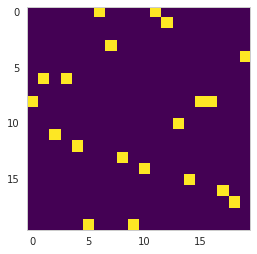

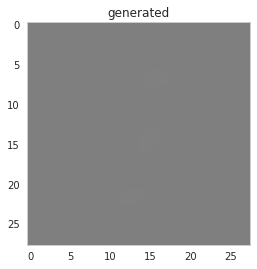

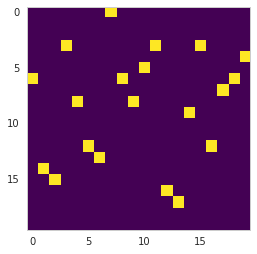

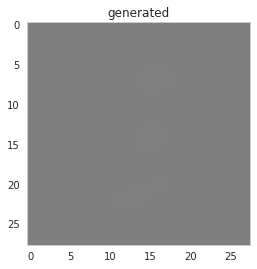

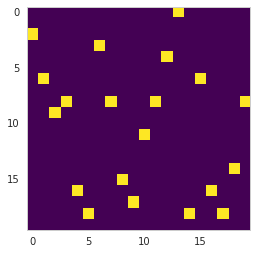

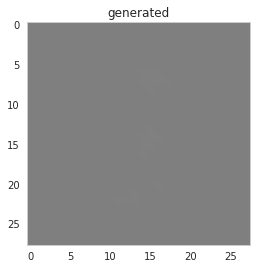

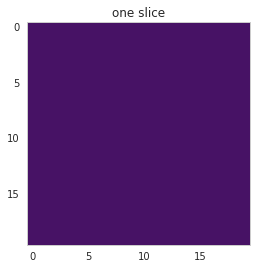

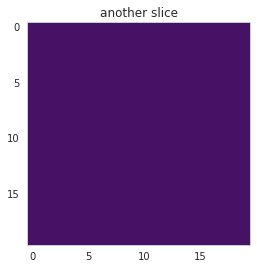

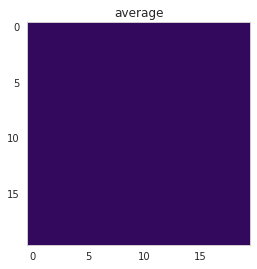

Iter: 0
Loss: 0.6117
()


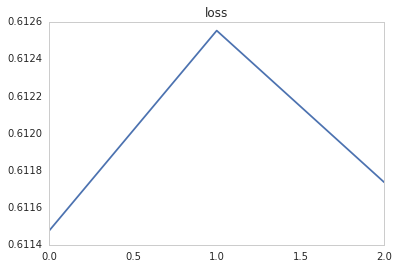

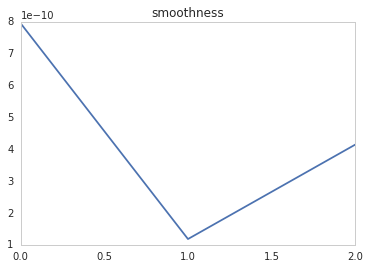

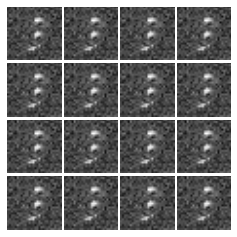

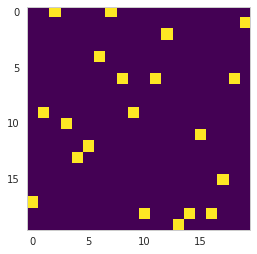

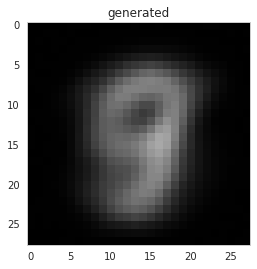

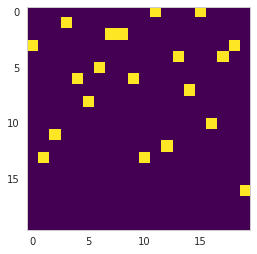

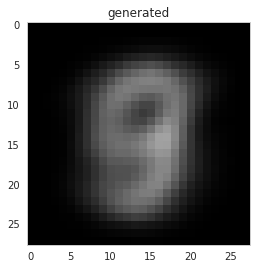

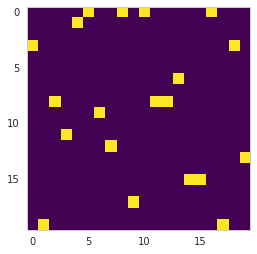

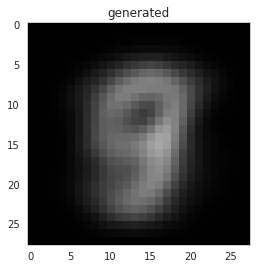

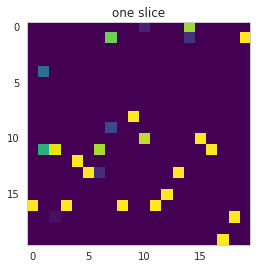

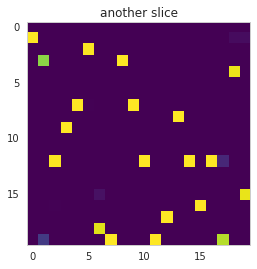

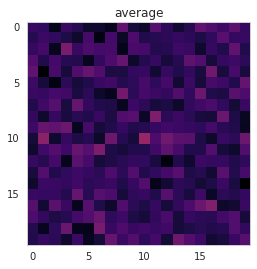

Iter: 5512
Loss: 0.1667
()


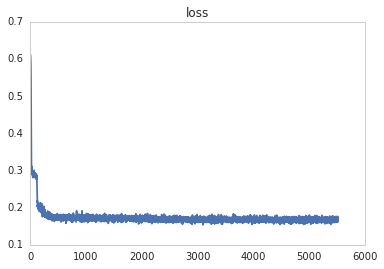

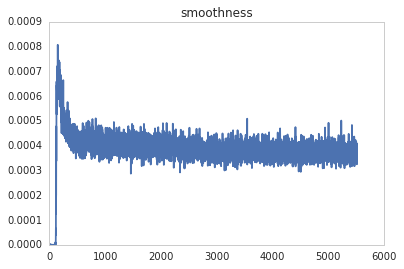

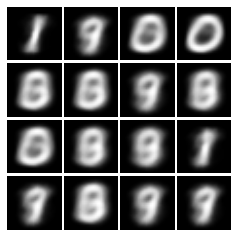

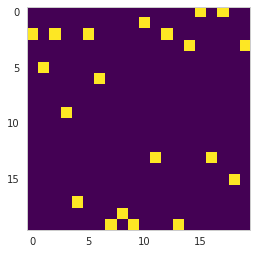

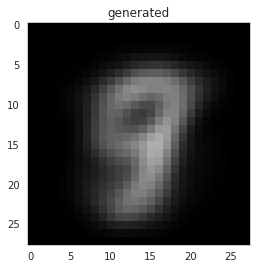

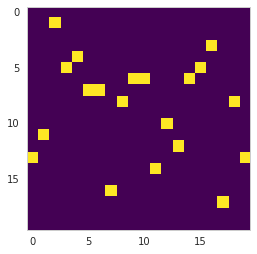

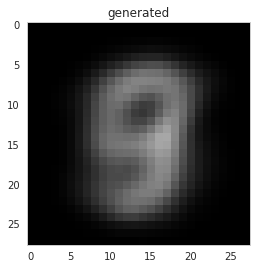

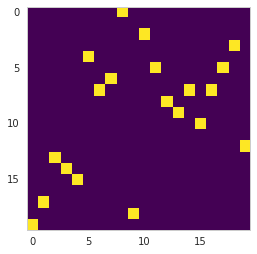

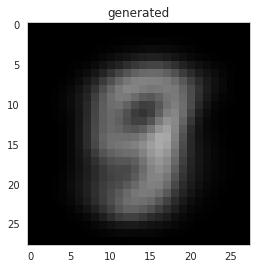

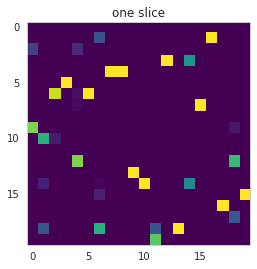

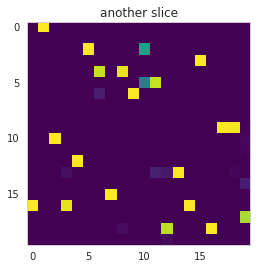

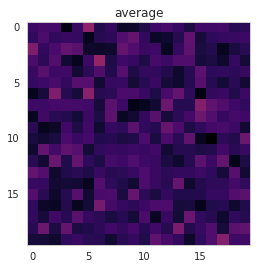

Iter: 11024
Loss: 0.1711
()


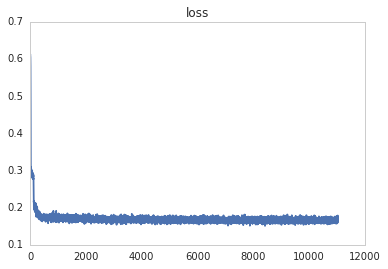

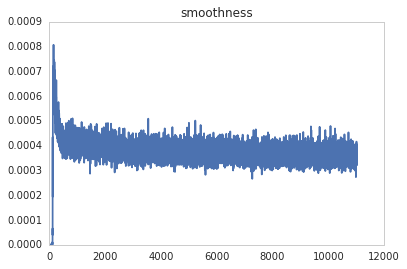

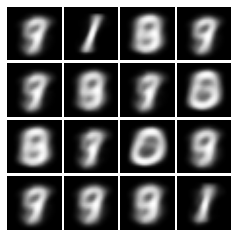

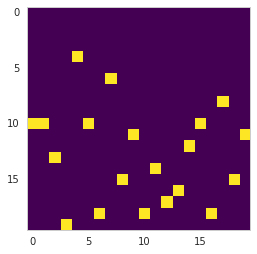

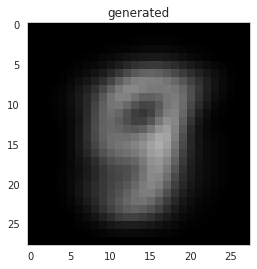

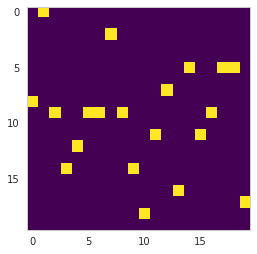

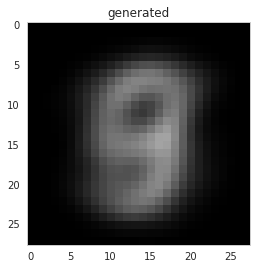

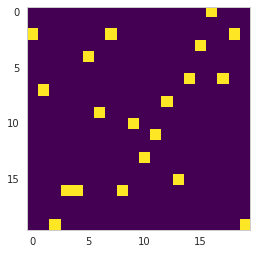

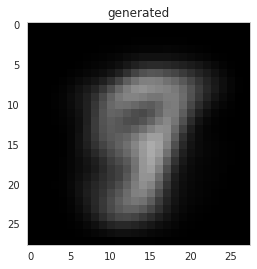

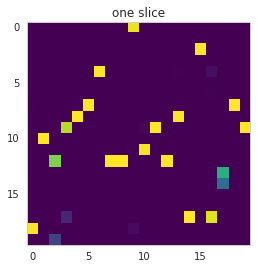

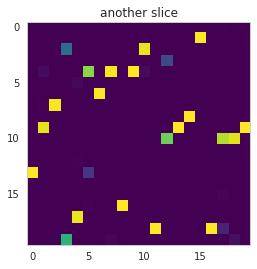

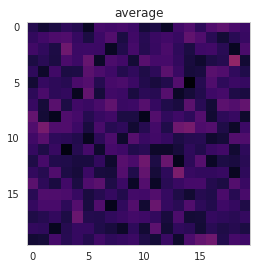

Iter: 16536
Loss: 0.1613
()


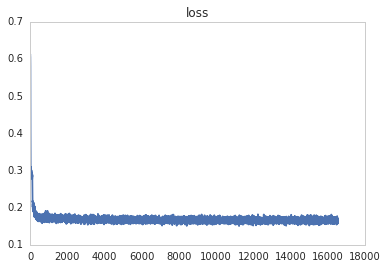

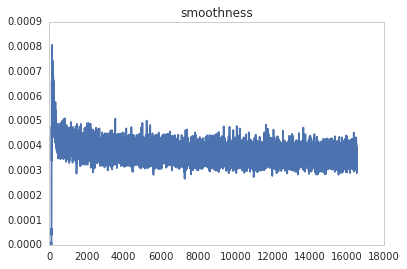

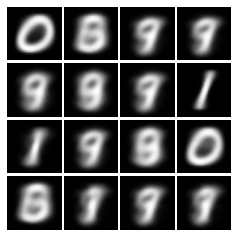

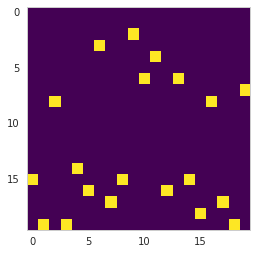

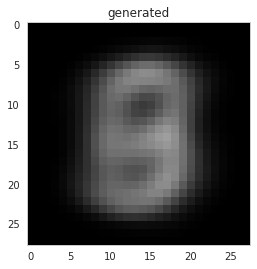

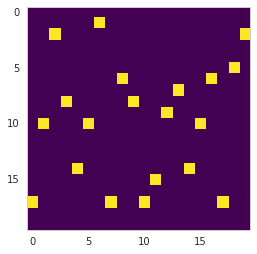

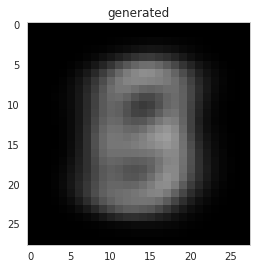

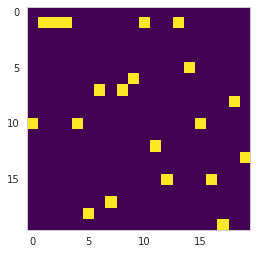

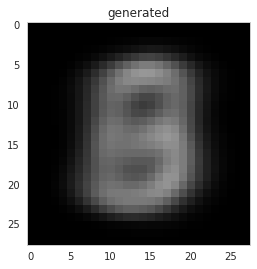

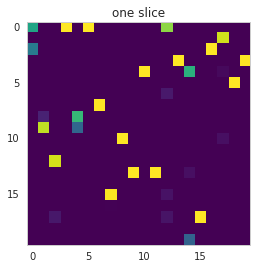

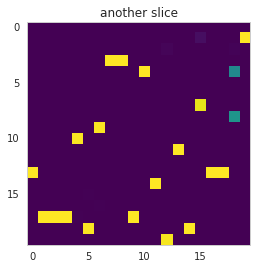

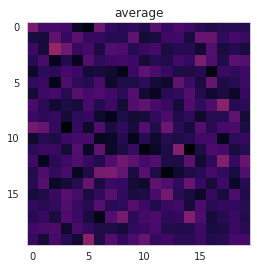

Iter: 22048
Loss: 0.1676
()


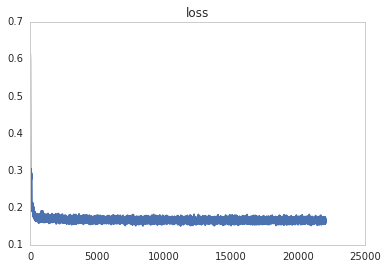

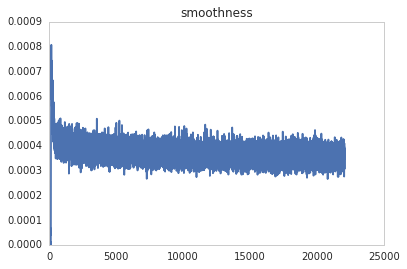

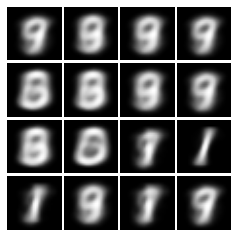

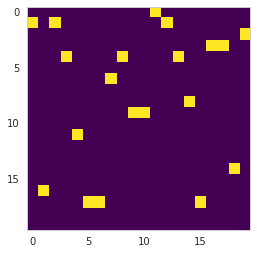

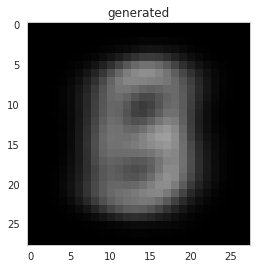

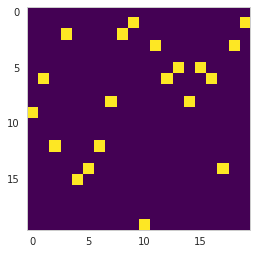

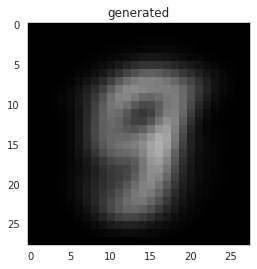

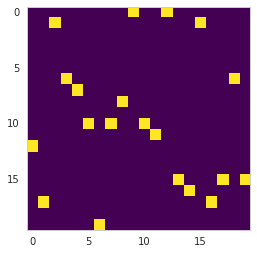

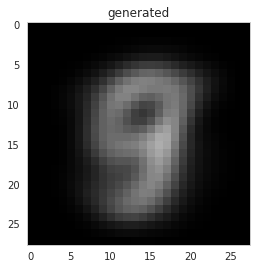

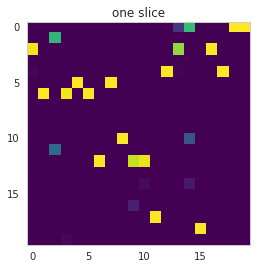

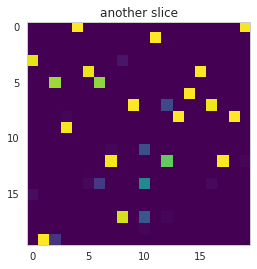

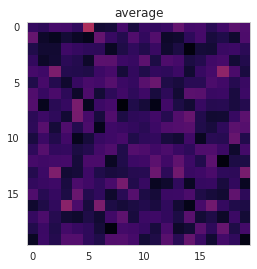

Iter: 27560
Loss: 0.1639
()


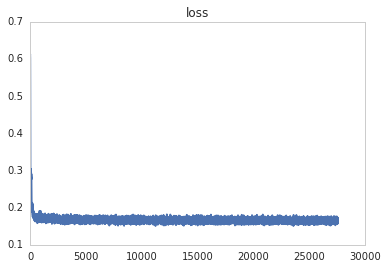

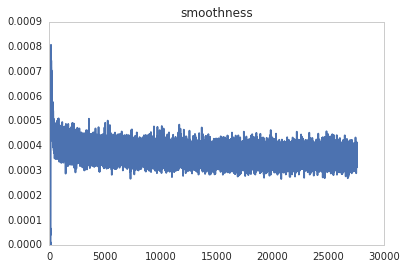

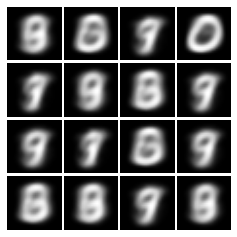

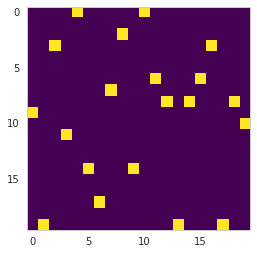

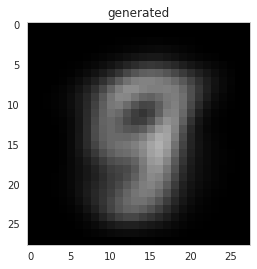

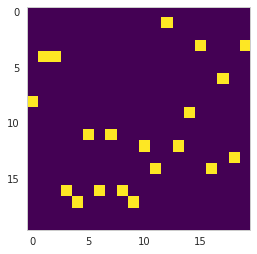

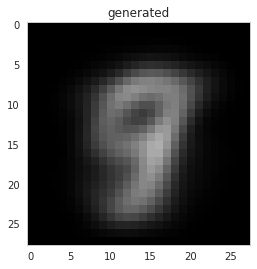

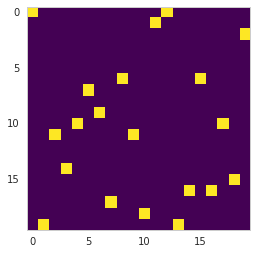

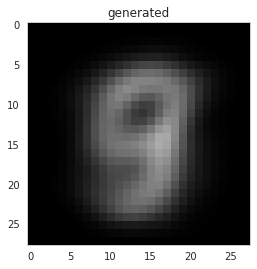

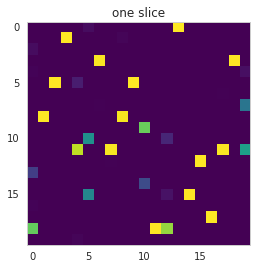

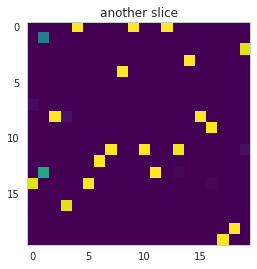

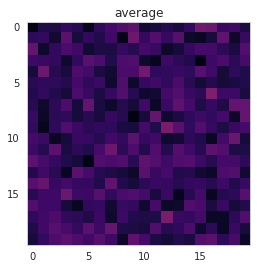

Iter: 33072
Loss: 0.1631
()


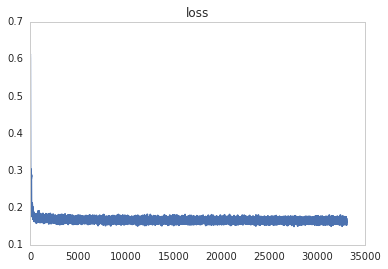

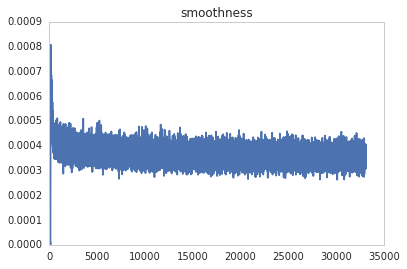

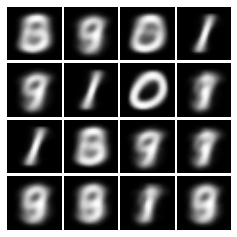

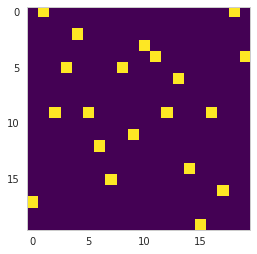

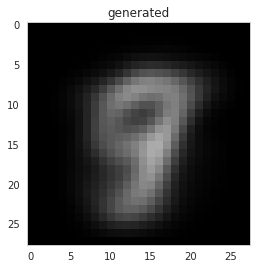

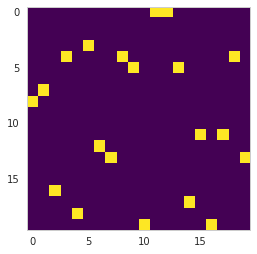

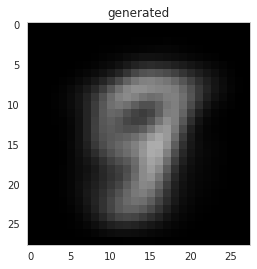

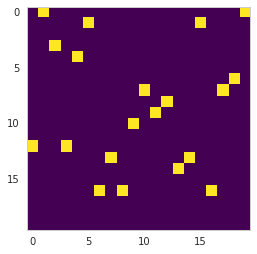

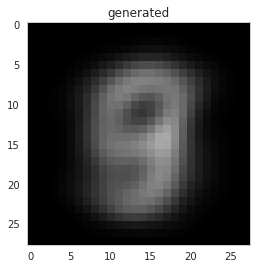

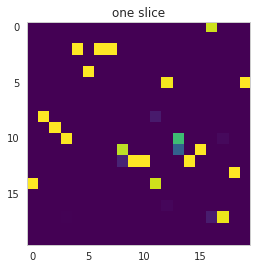

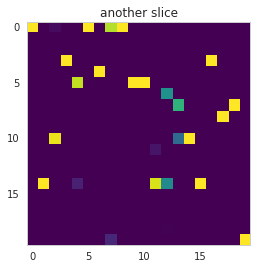

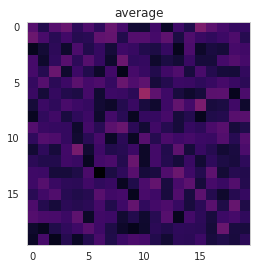

Iter: 38584
Loss: 0.1586
()


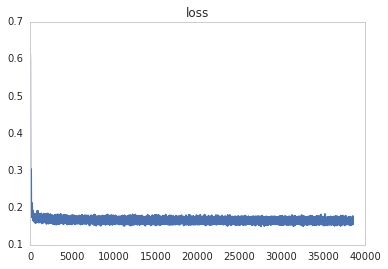

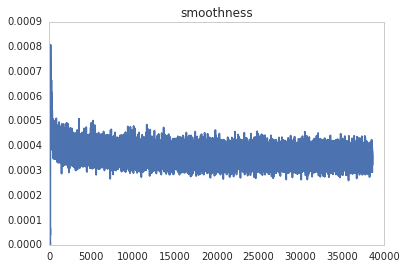

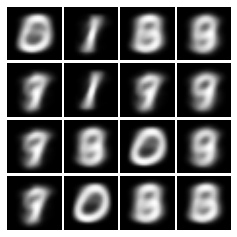

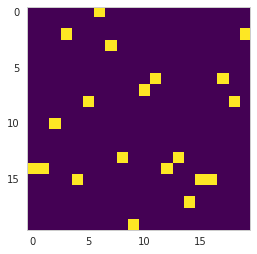

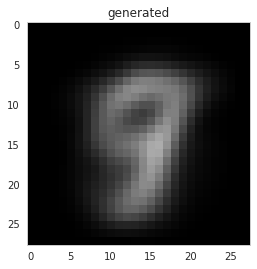

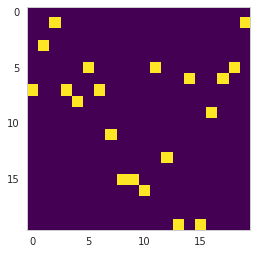

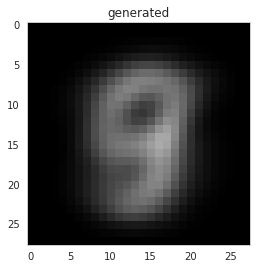

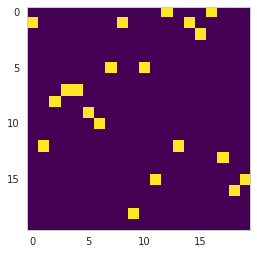

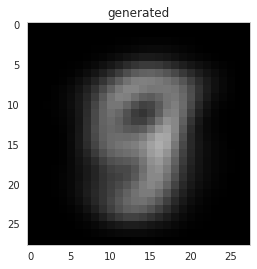

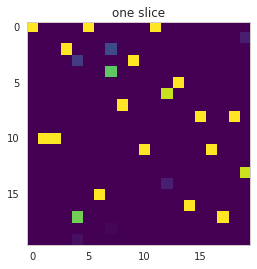

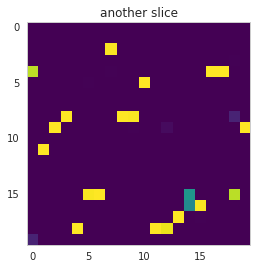

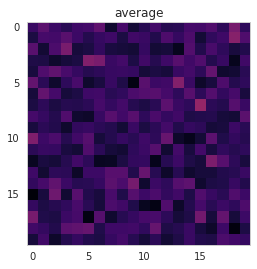

Iter: 44096
Loss: 0.1646
()


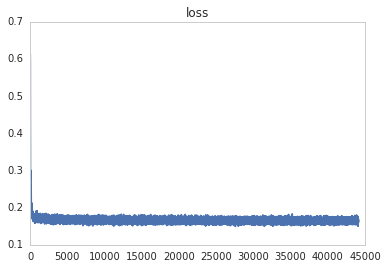

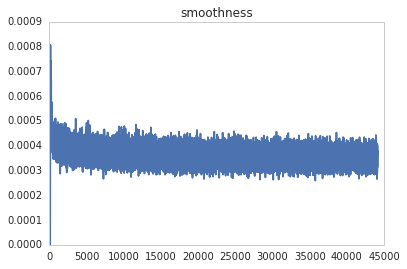

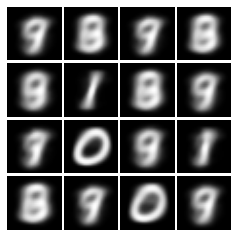

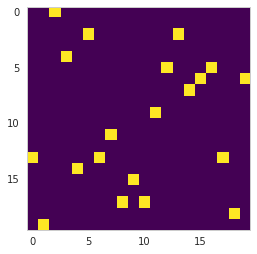

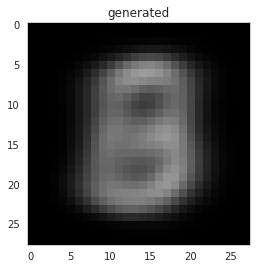

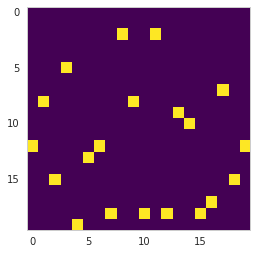

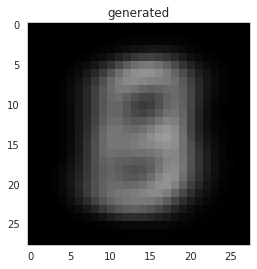

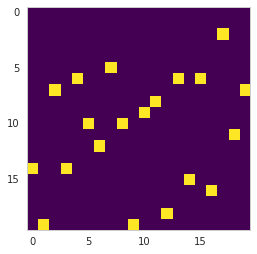

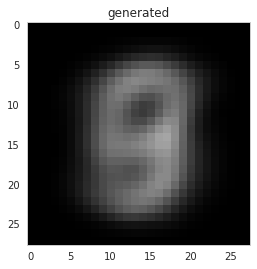

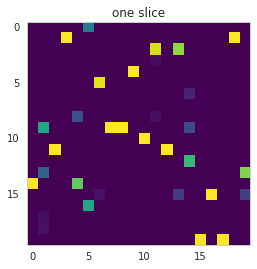

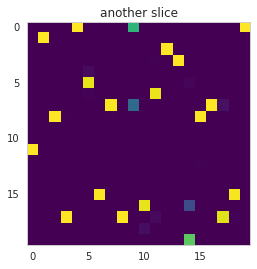

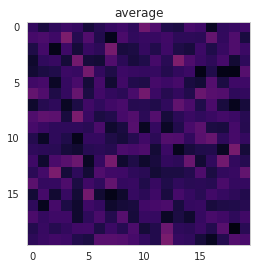

Iter: 49608
Loss: 0.1637
()


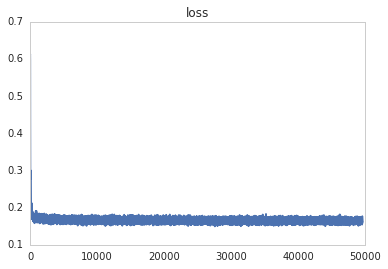

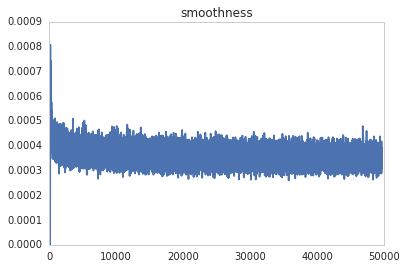

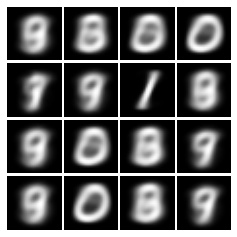

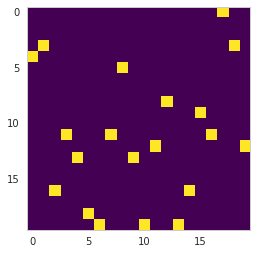

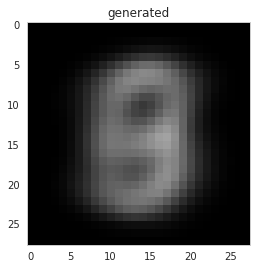

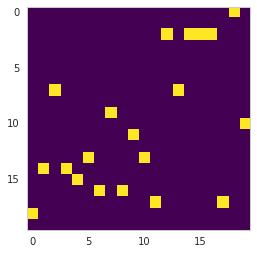

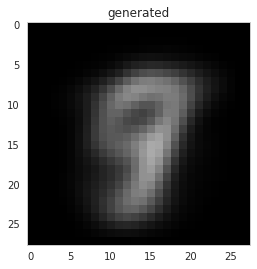

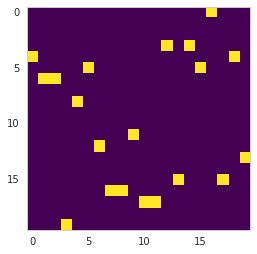

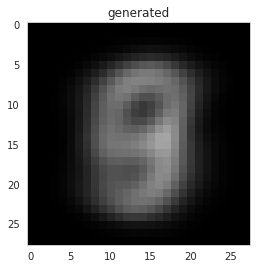

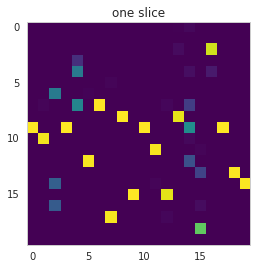

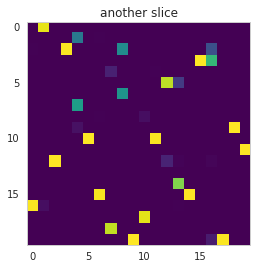

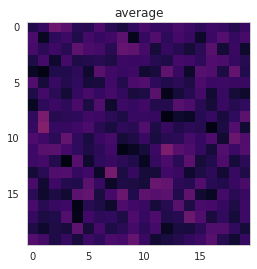

Iter: 55120
Loss: 0.1643
()


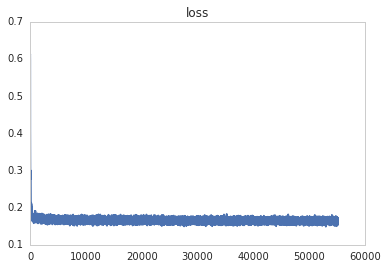

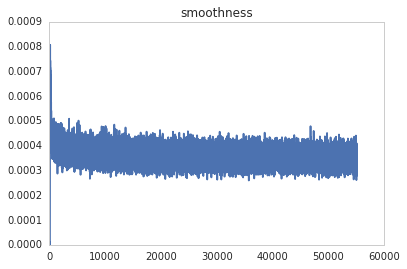

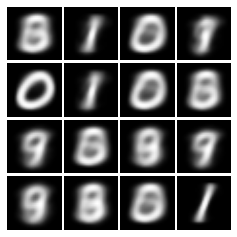

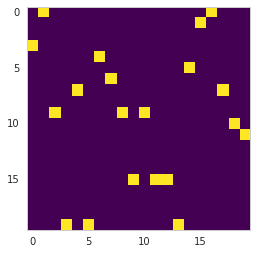

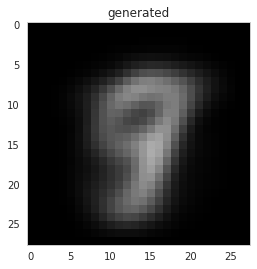

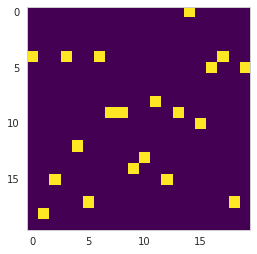

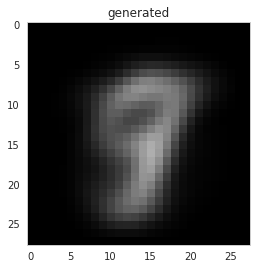

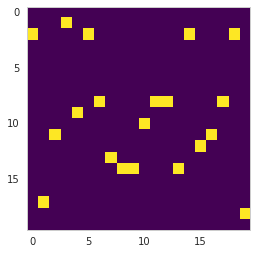

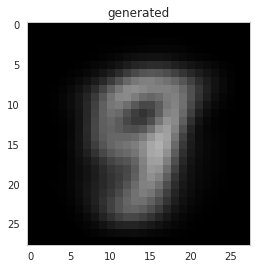

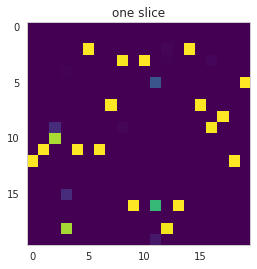

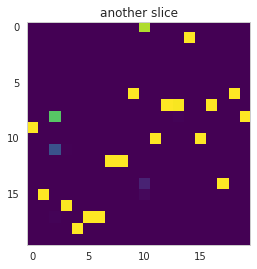

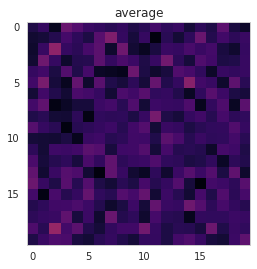

Iter: 60632
Loss: 0.1669
()


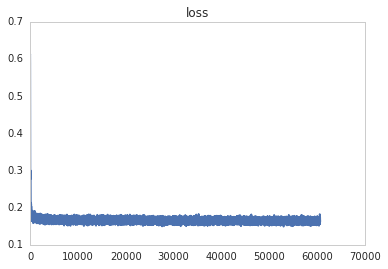

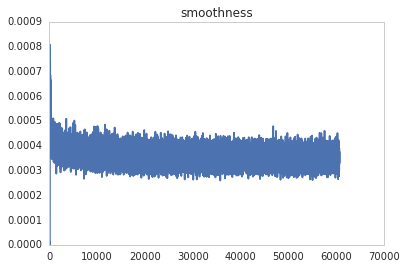

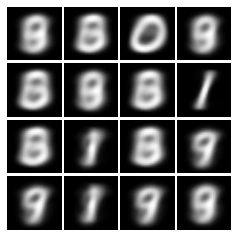

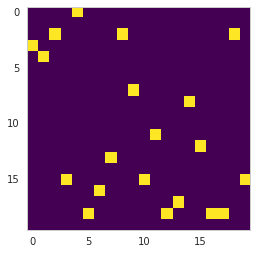

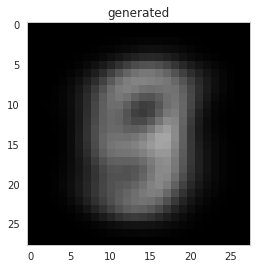

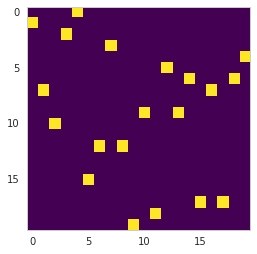

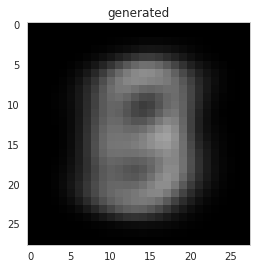

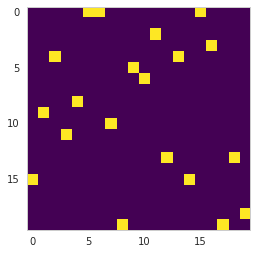

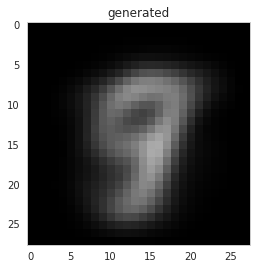

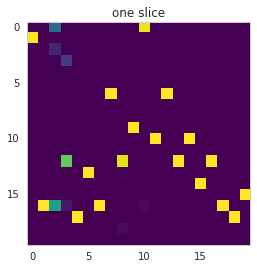

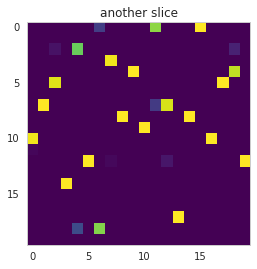

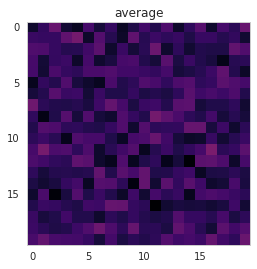

Iter: 66144
Loss: 0.158
()


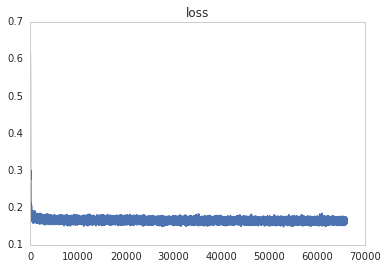

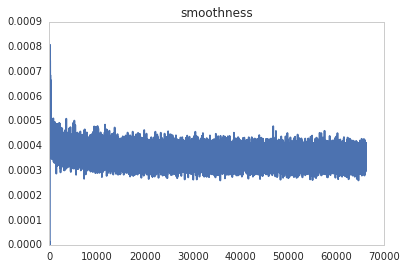

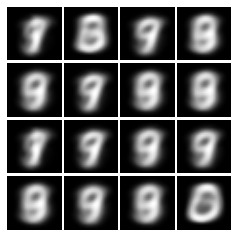

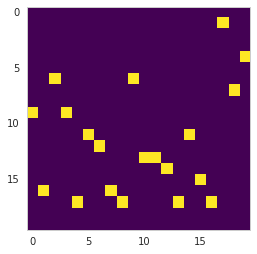

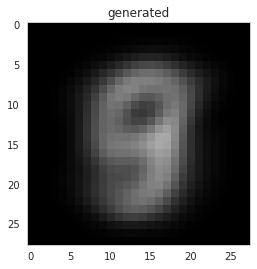

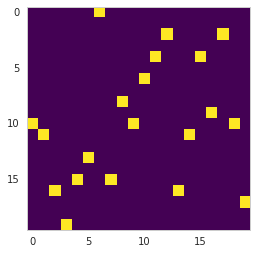

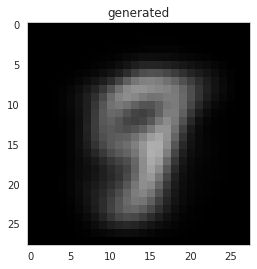

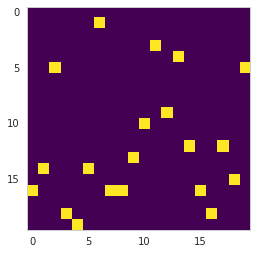

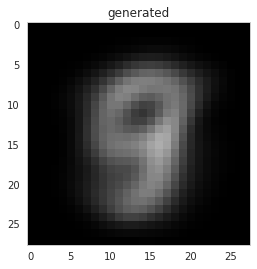

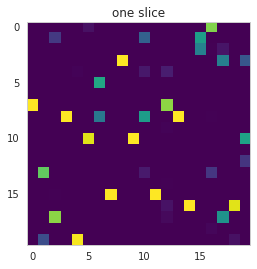

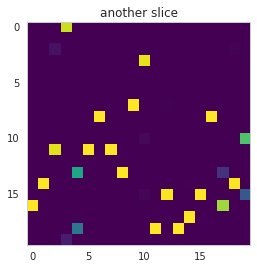

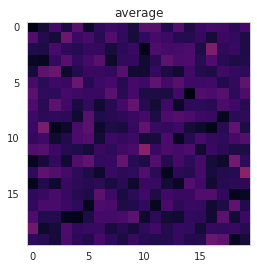

Iter: 71656
Loss: 0.1634
()


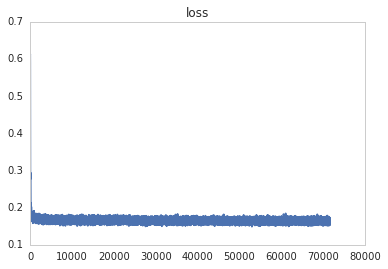

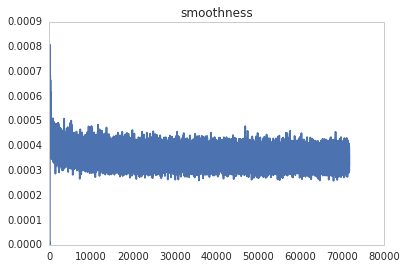

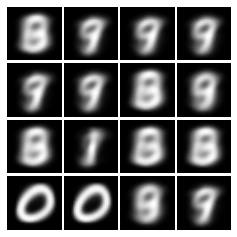

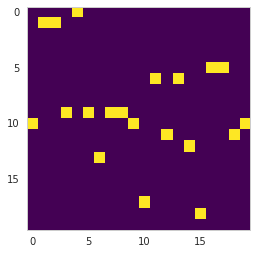

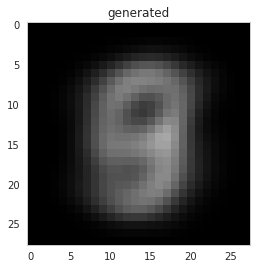

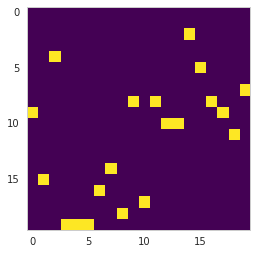

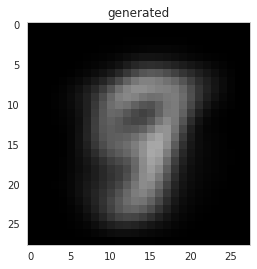

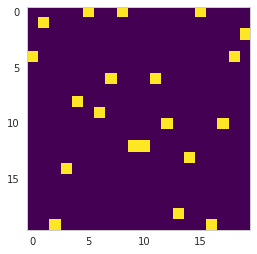

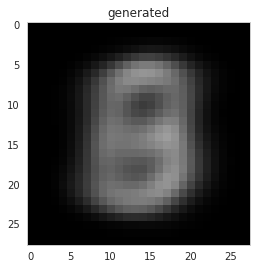

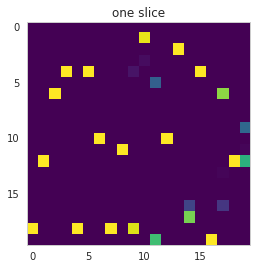

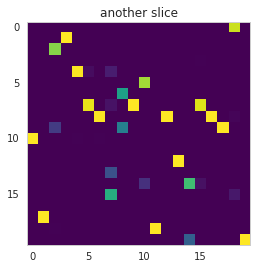

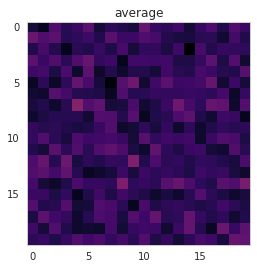

Iter: 77168
Loss: 0.1625
()


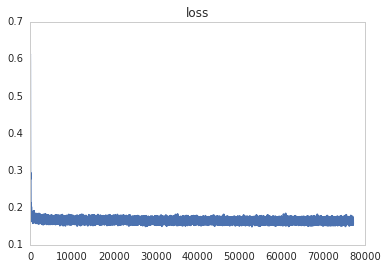

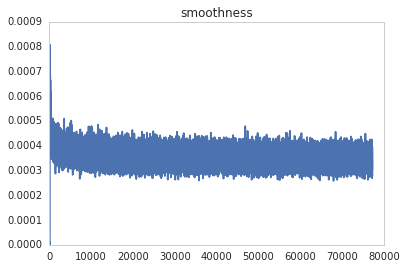

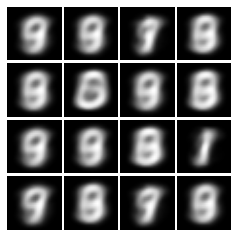

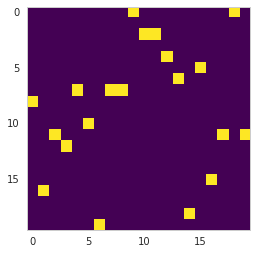

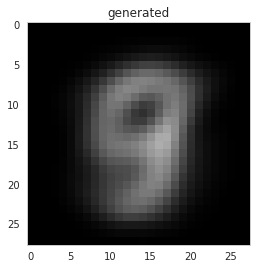

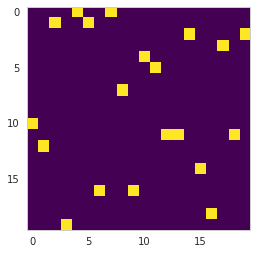

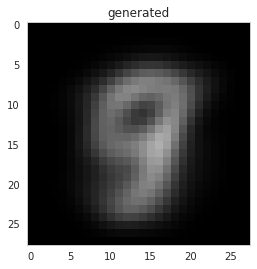

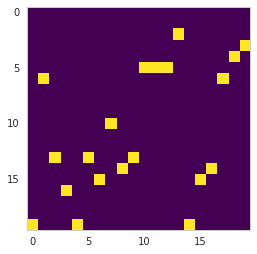

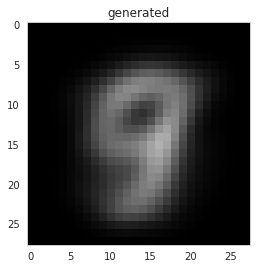

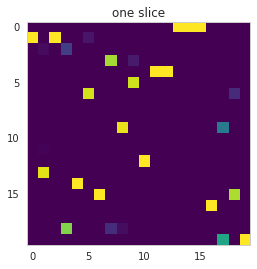

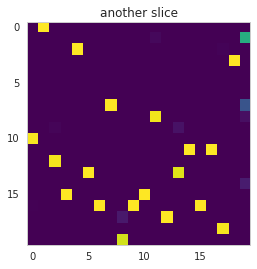

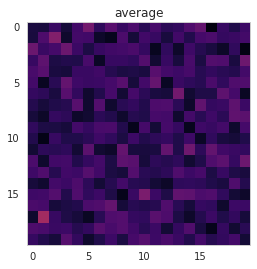

Iter: 82680
Loss: 0.1603
()


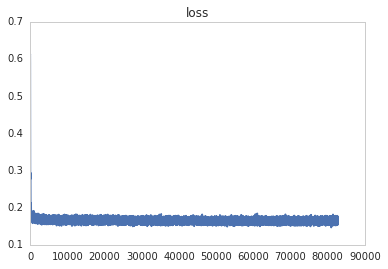

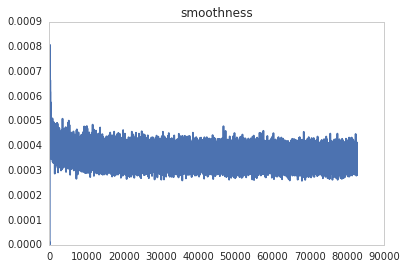

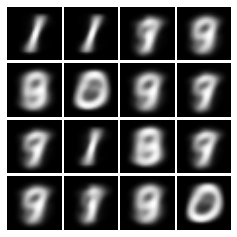

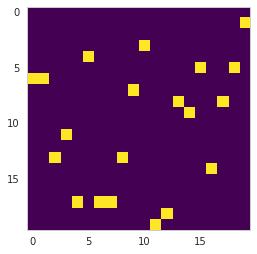

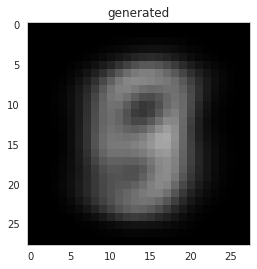

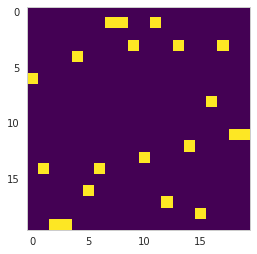

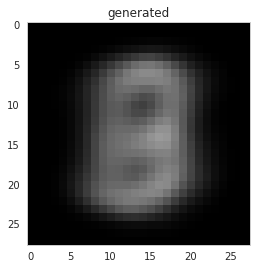

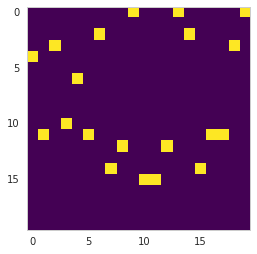

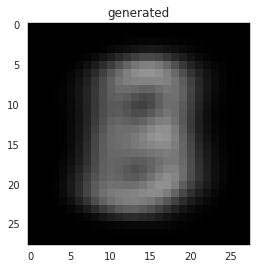

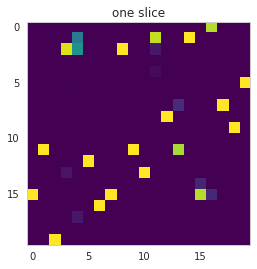

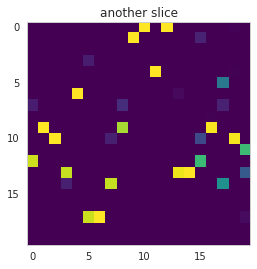

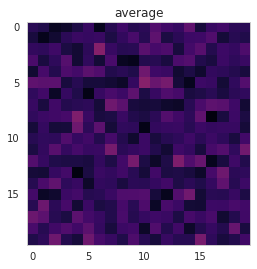

Iter: 88192
Loss: 0.1631
()


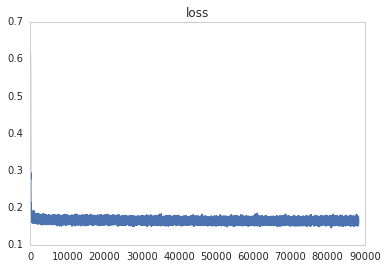

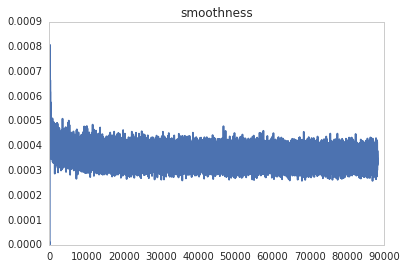

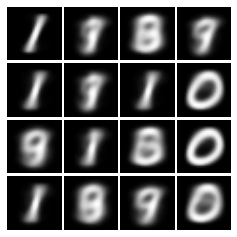

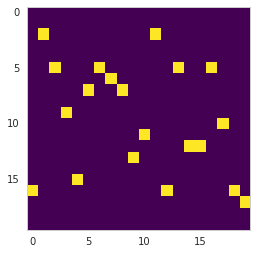

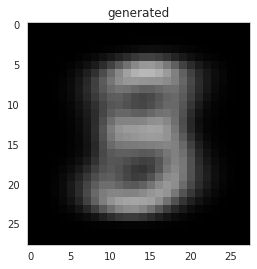

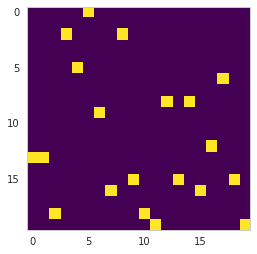

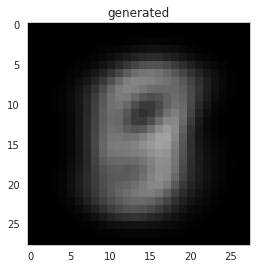

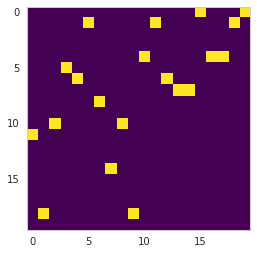

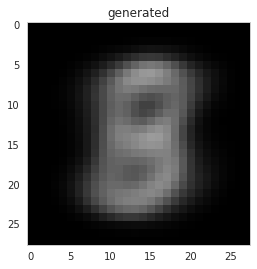

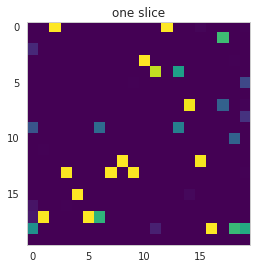

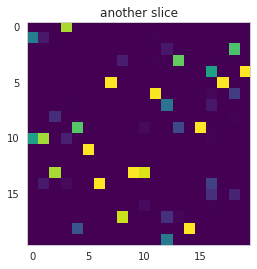

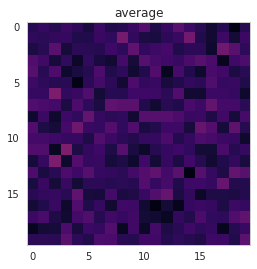

Iter: 93704
Loss: 0.1543
()


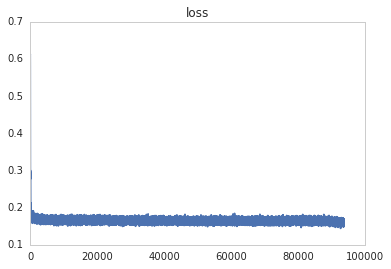

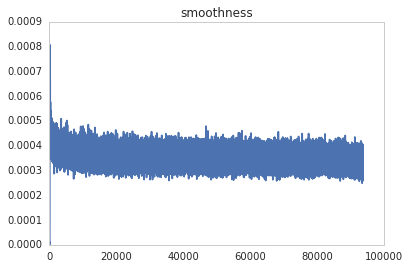

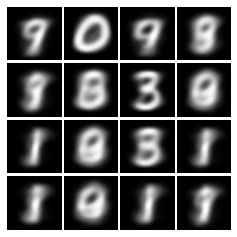

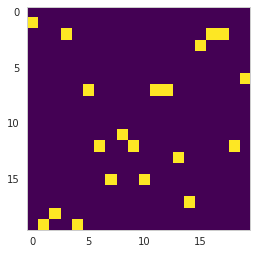

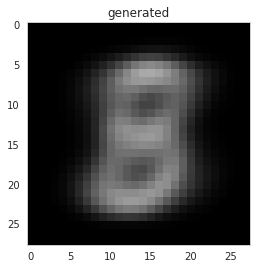

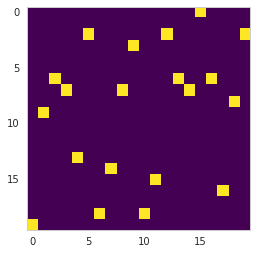

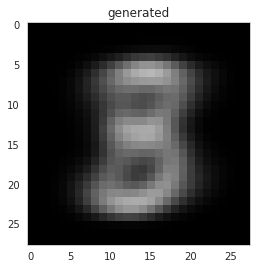

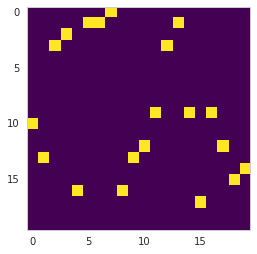

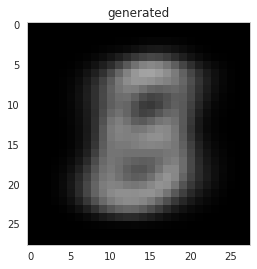

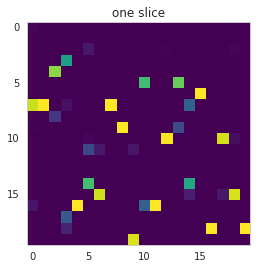

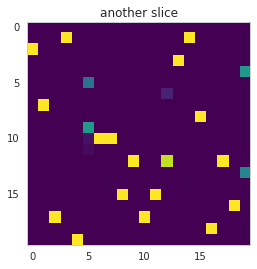

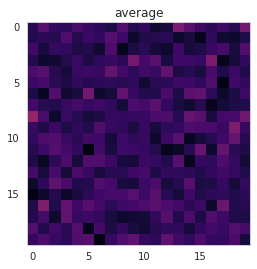

Iter: 99216
Loss: 0.1559
()


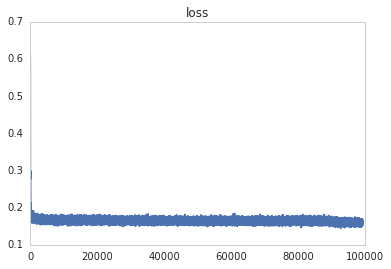

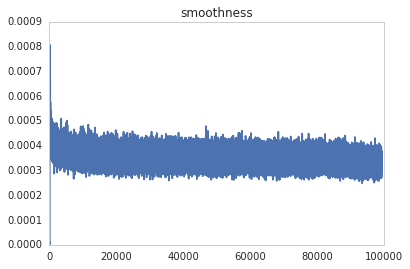

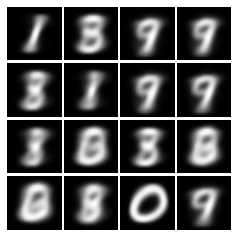

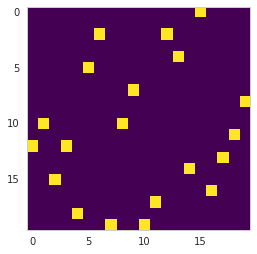

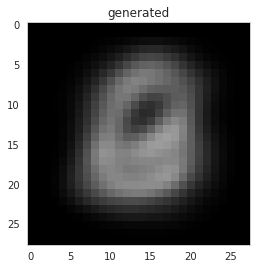

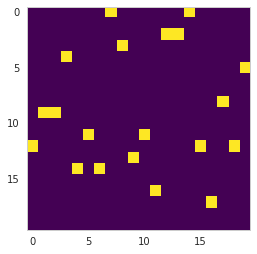

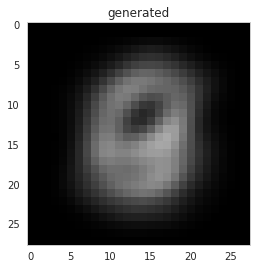

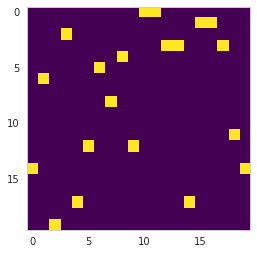

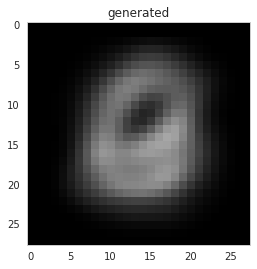

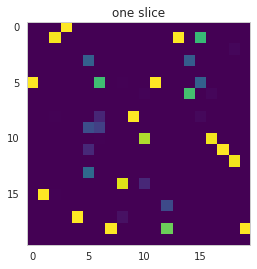

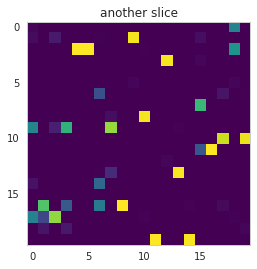

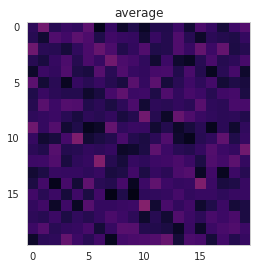

Iter: 104728
Loss: 0.1536
()


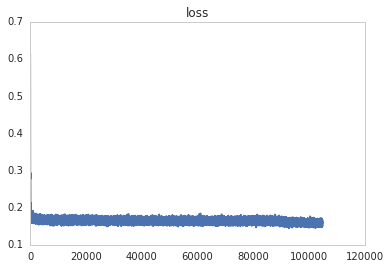

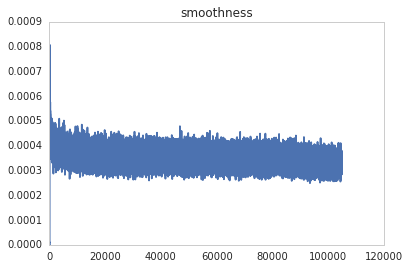

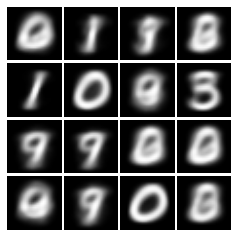

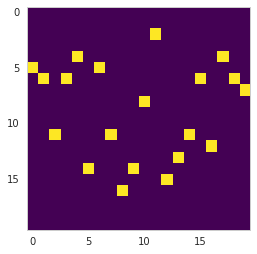

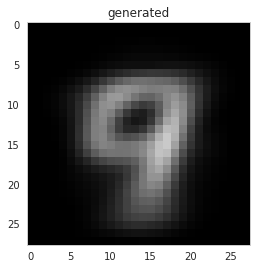

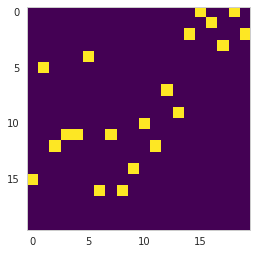

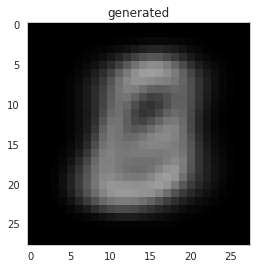

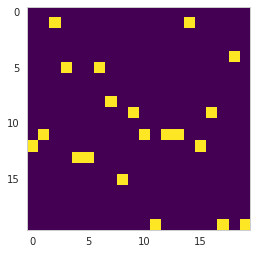

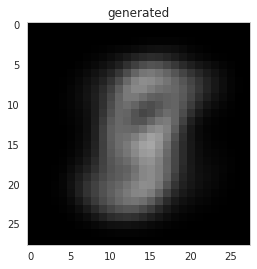

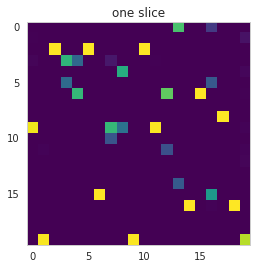

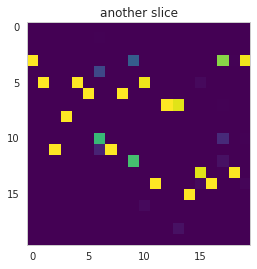

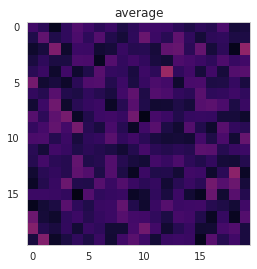

Iter: 110240
Loss: 0.1708
()


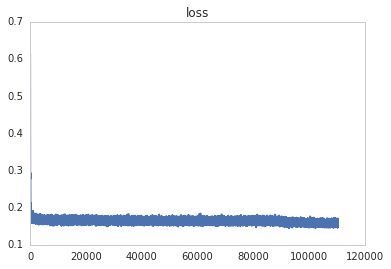

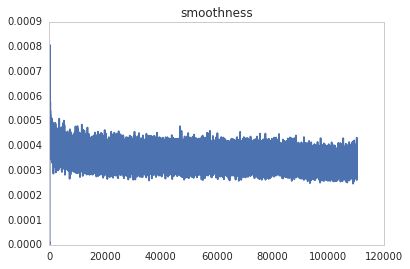

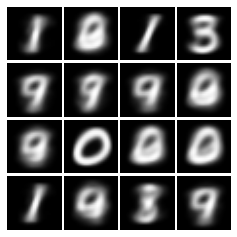

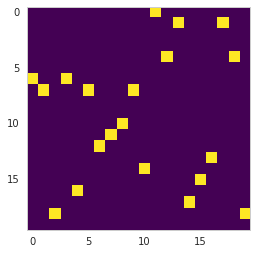

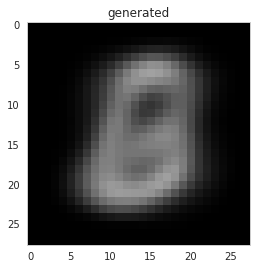

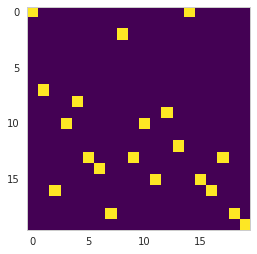

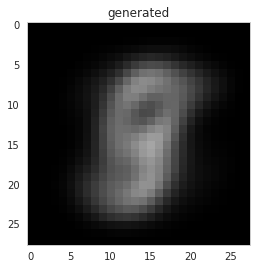

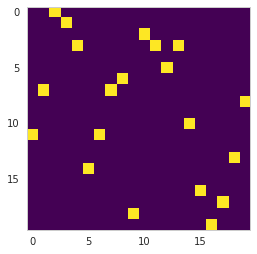

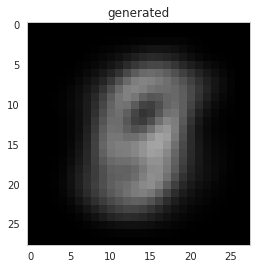

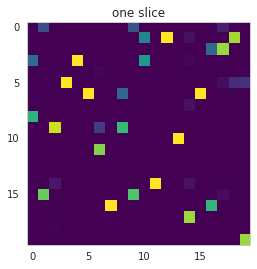

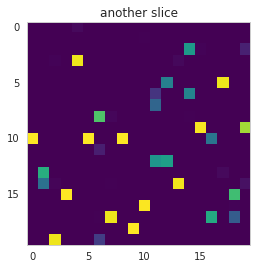

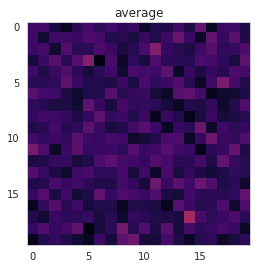

Iter: 115752
Loss: 0.1604
()


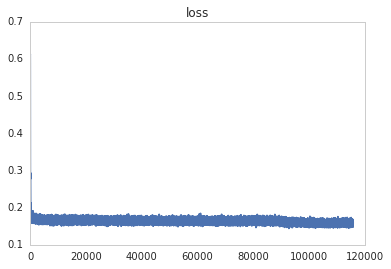

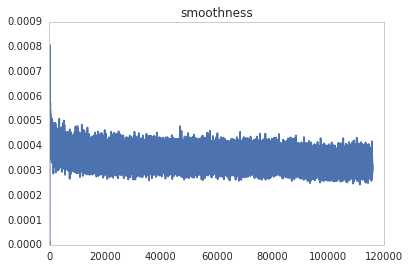

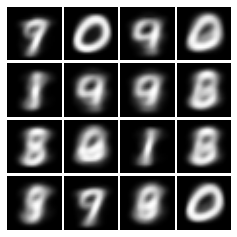

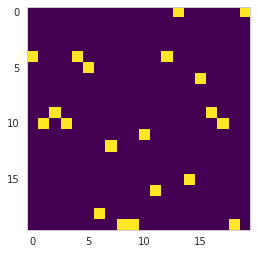

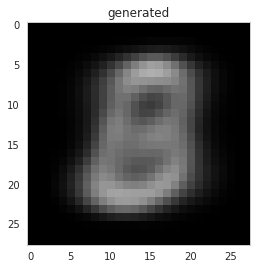

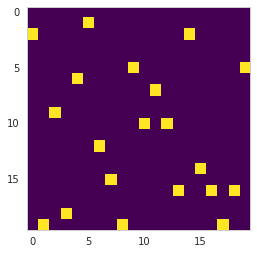

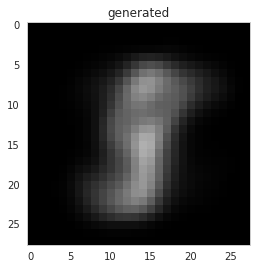

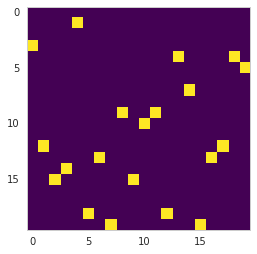

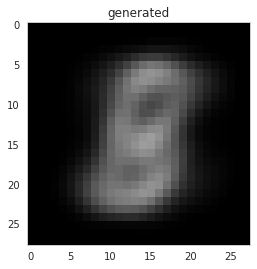

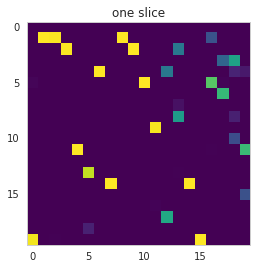

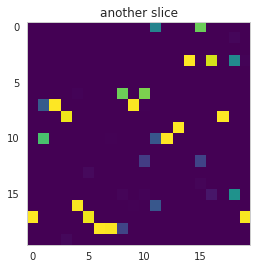

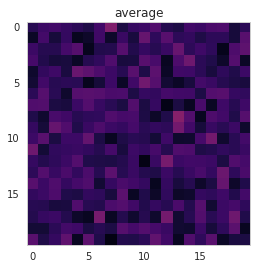

Iter: 121264
Loss: 0.162
()


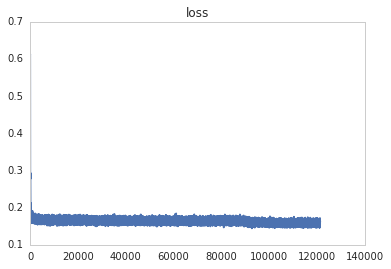

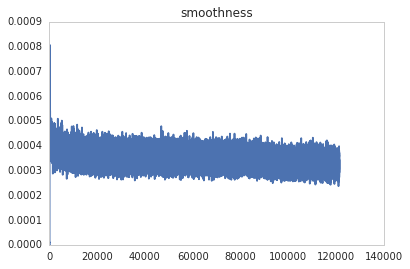

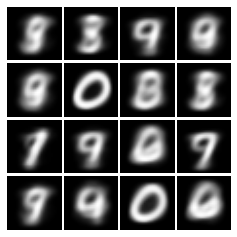

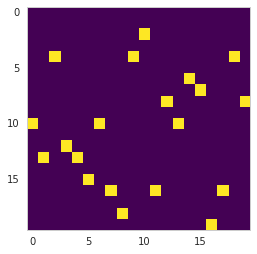

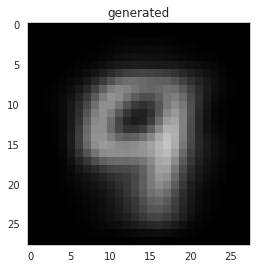

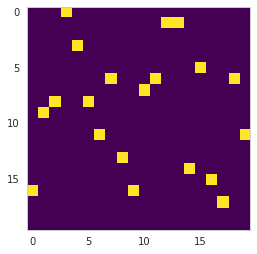

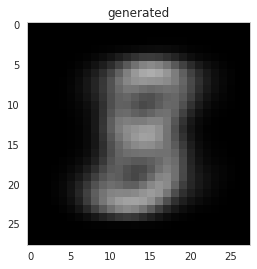

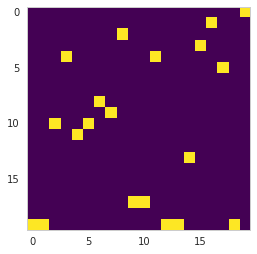

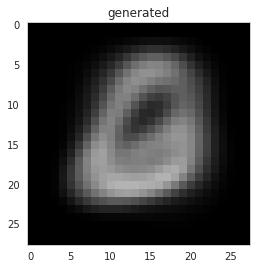

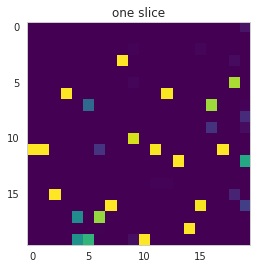

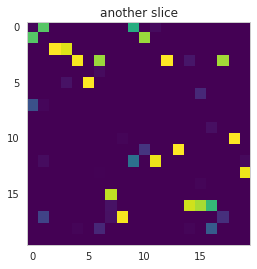

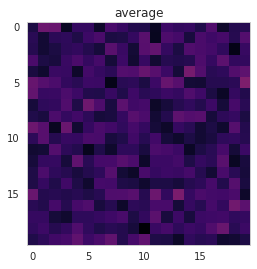

Iter: 126776
Loss: 0.1574
()


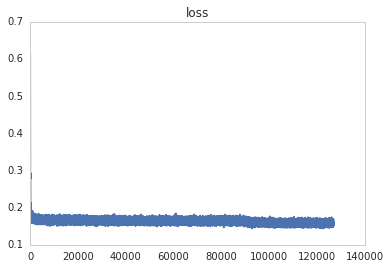

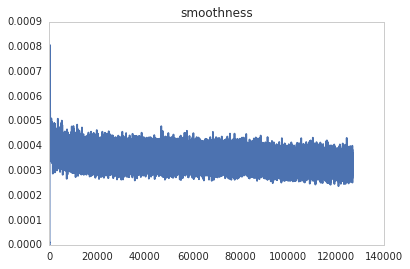

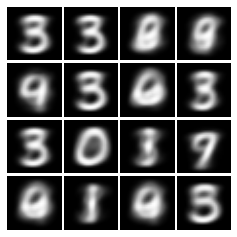

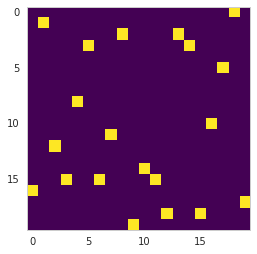

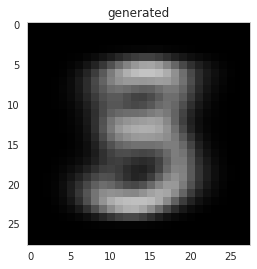

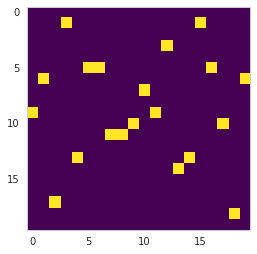

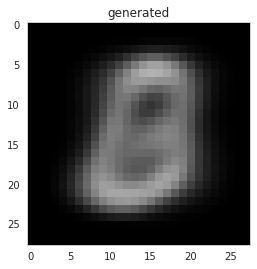

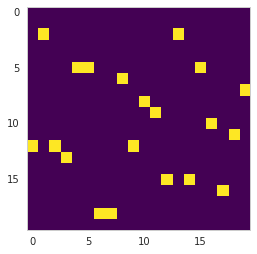

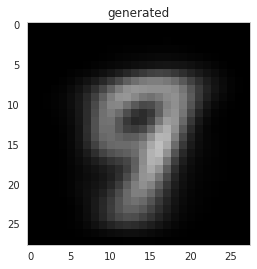

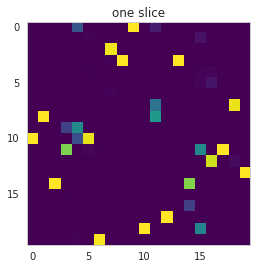

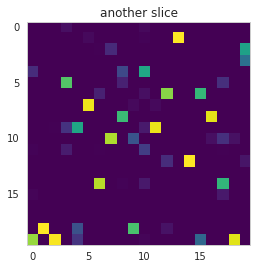

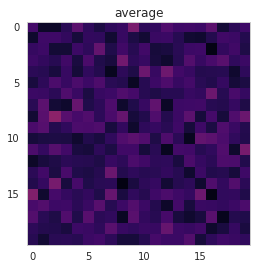

Iter: 132288
Loss: 0.1553
()


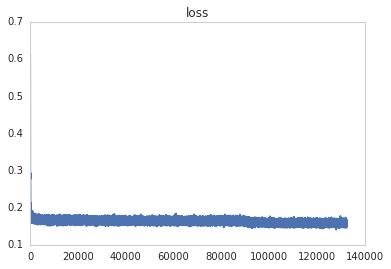

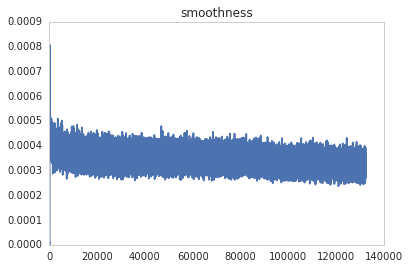

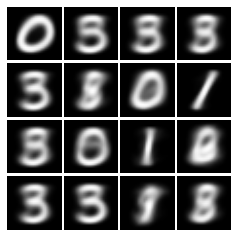

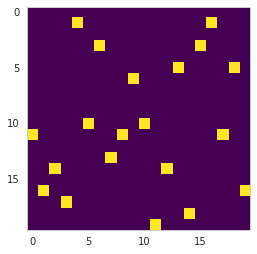

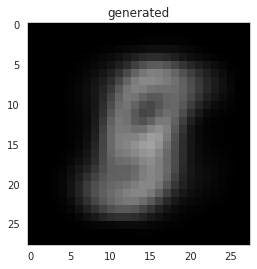

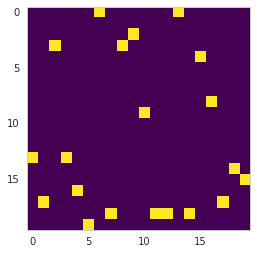

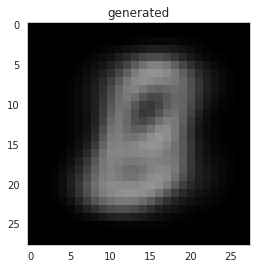

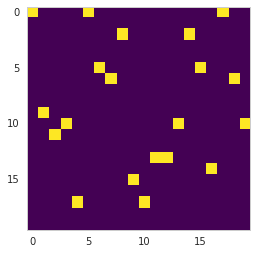

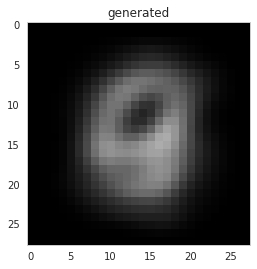

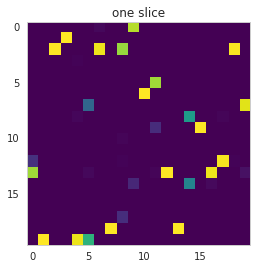

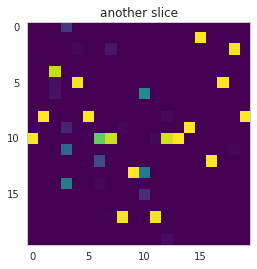

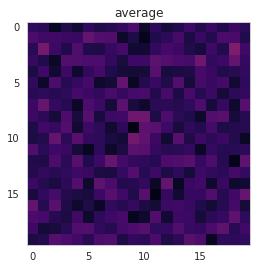

Iter: 137800
Loss: 0.1559
()


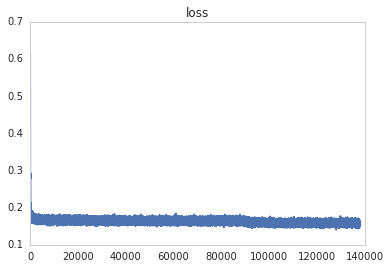

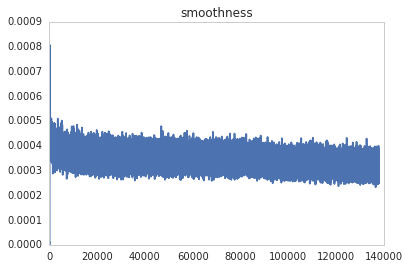

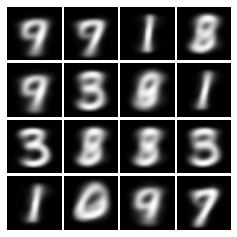

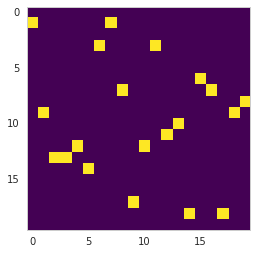

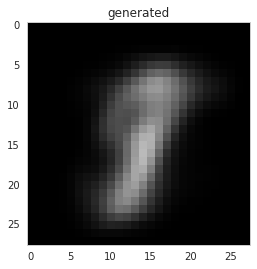

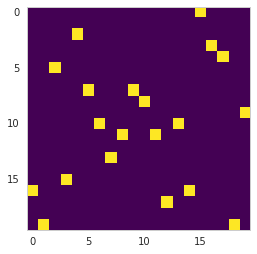

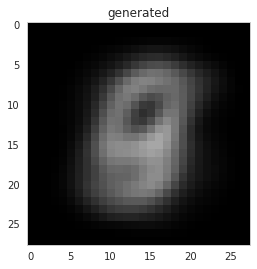

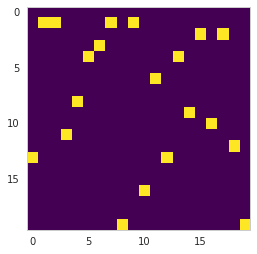

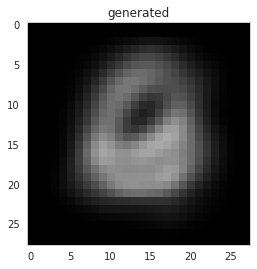

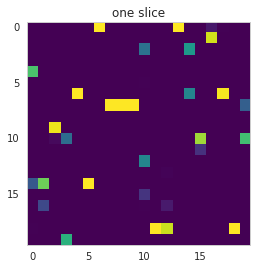

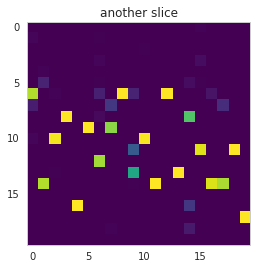

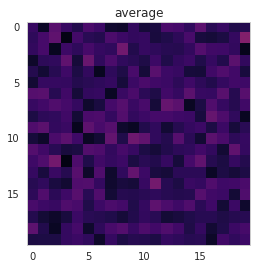

Iter: 143312
Loss: 0.1516
()


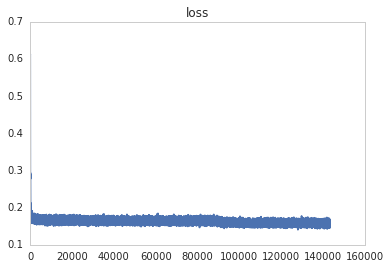

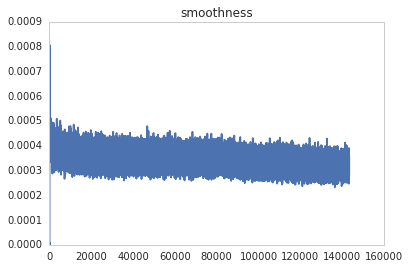

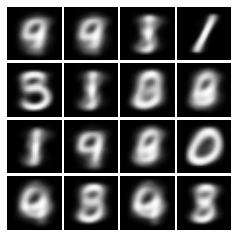

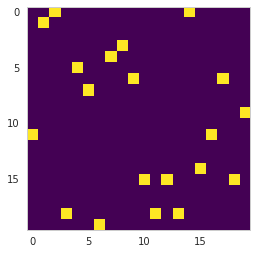

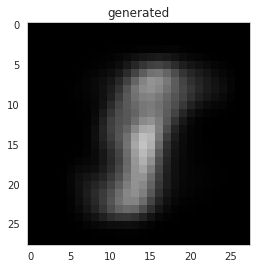

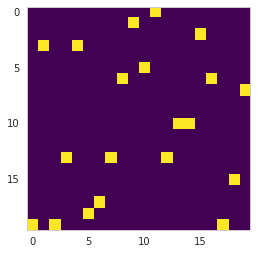

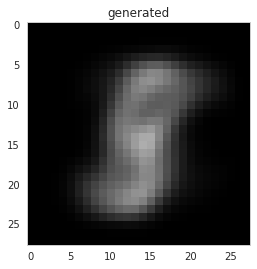

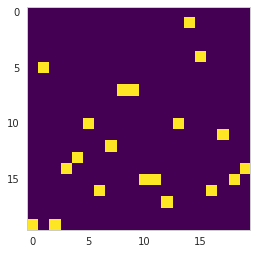

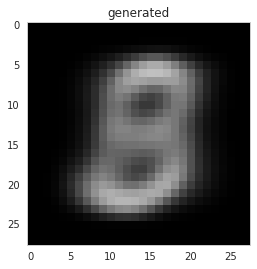

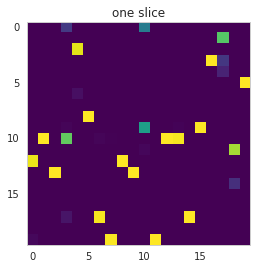

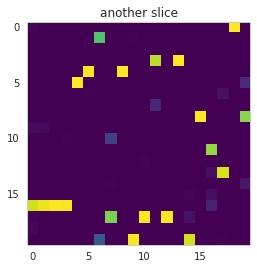

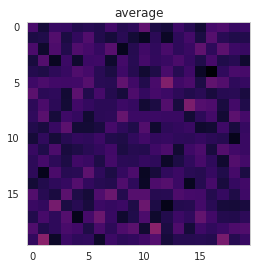

Iter: 148824
Loss: 0.152
()


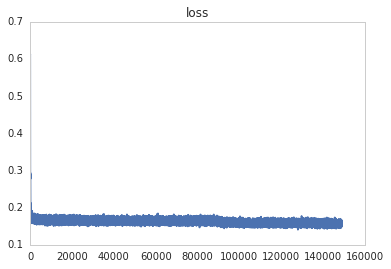

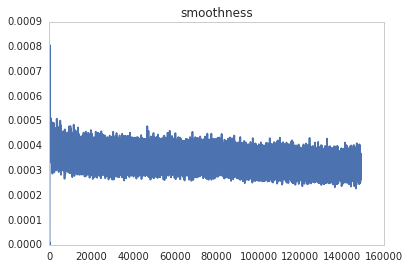

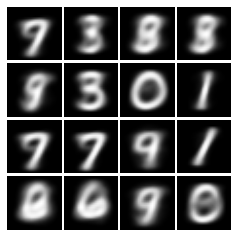

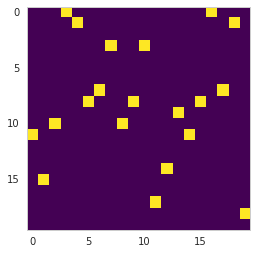

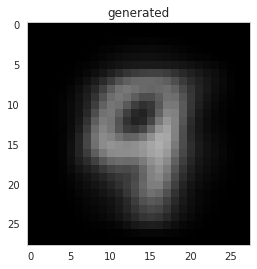

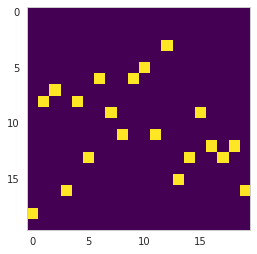

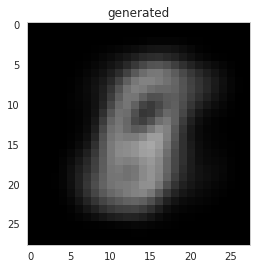

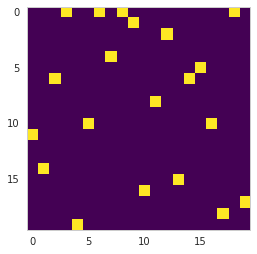

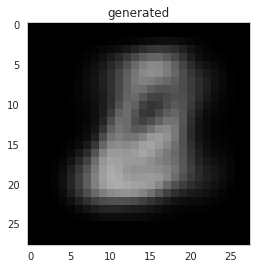

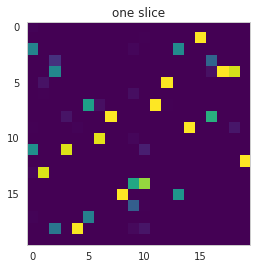

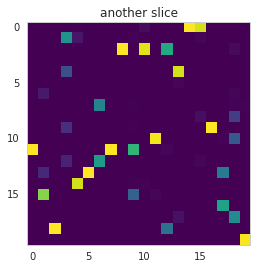

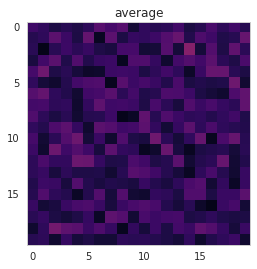

Iter: 154336
Loss: 0.1627
()


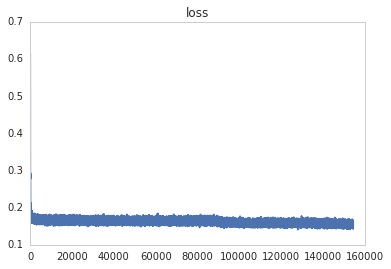

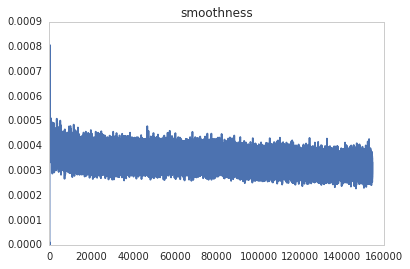

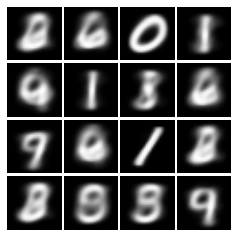

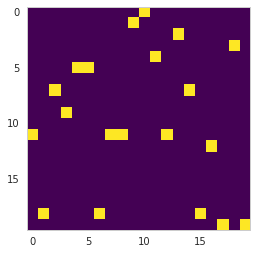

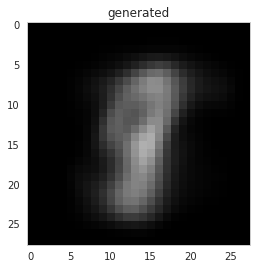

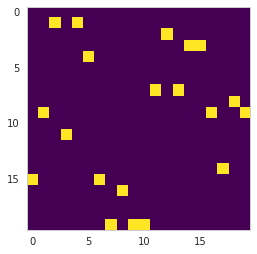

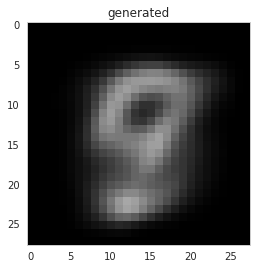

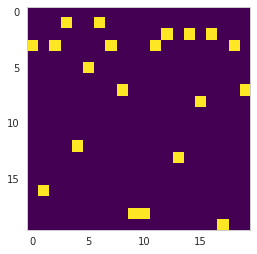

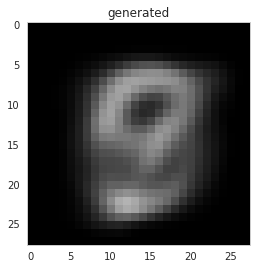

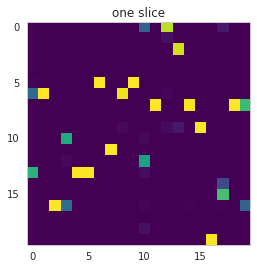

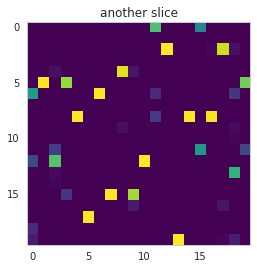

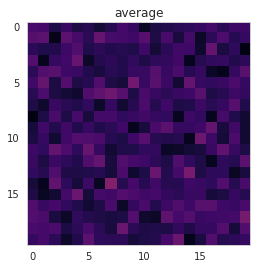

Iter: 159848
Loss: 0.1575
()


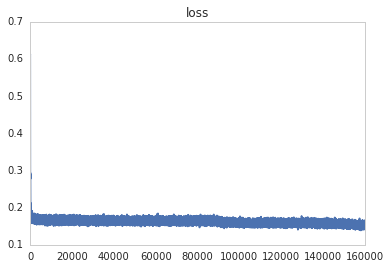

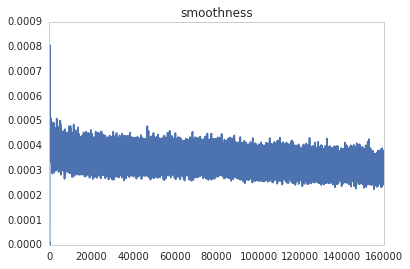

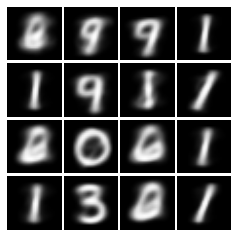

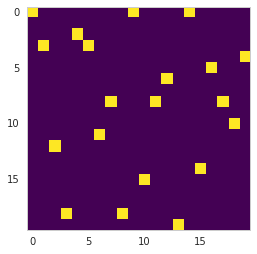

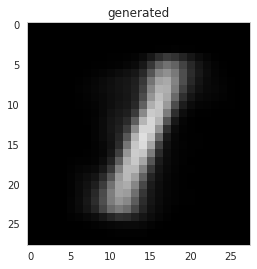

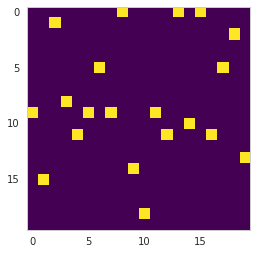

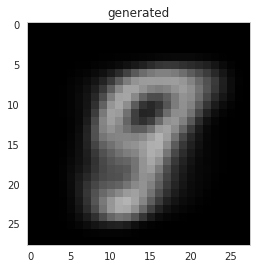

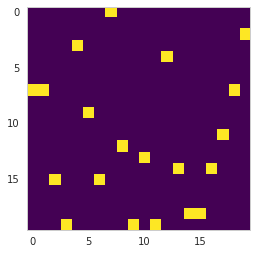

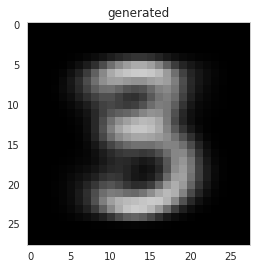

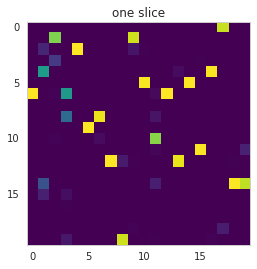

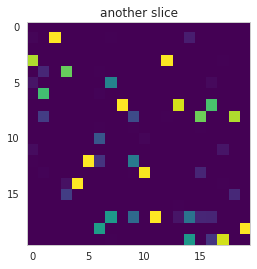

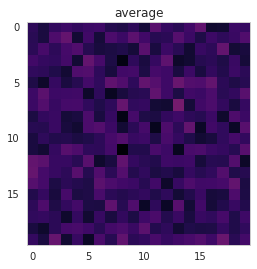

Iter: 165360
Loss: 0.1522
()


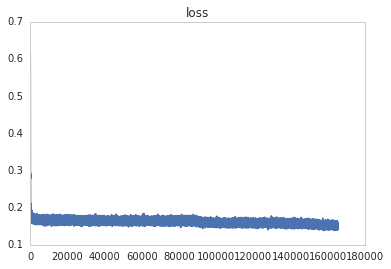

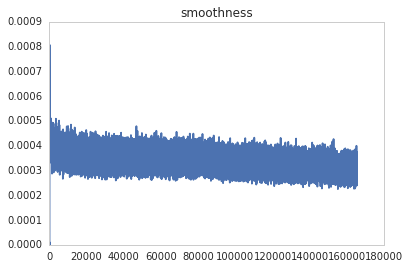

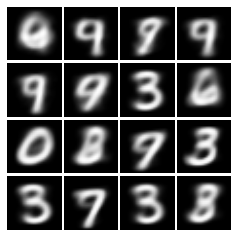

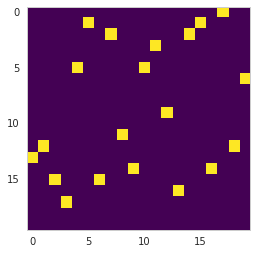

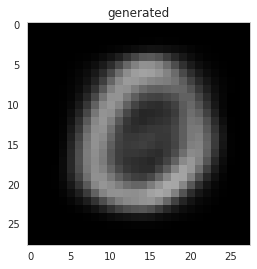

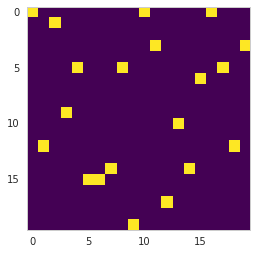

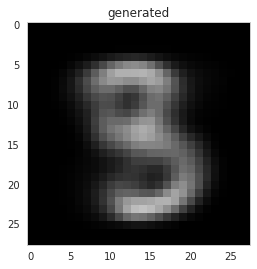

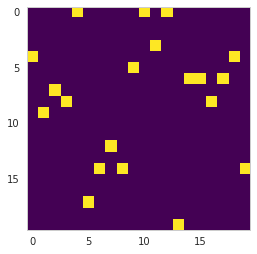

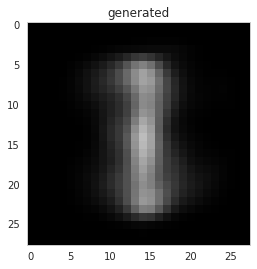

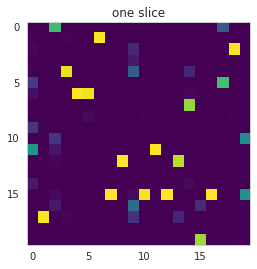

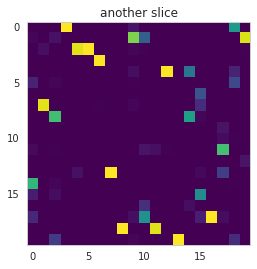

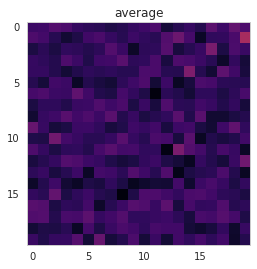

Iter: 170872
Loss: 0.146
()


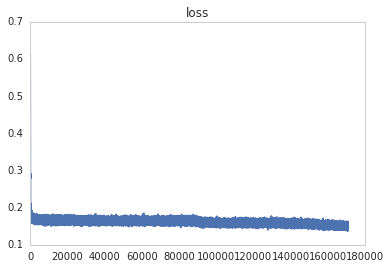

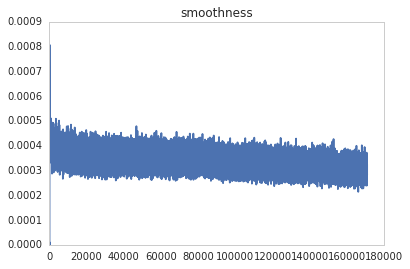

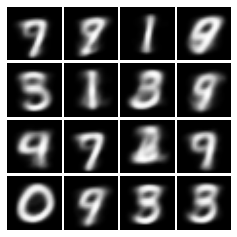

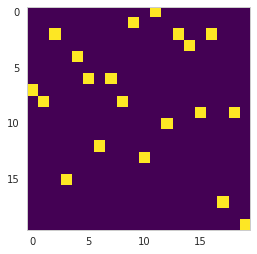

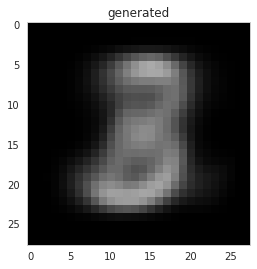

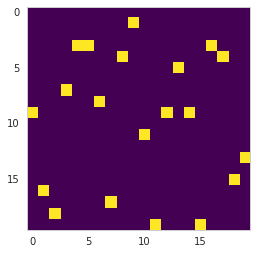

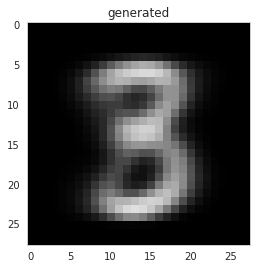

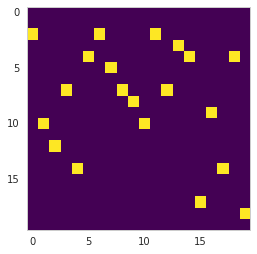

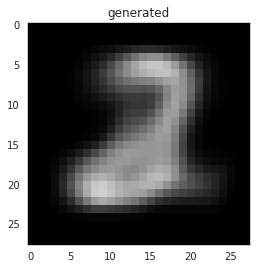

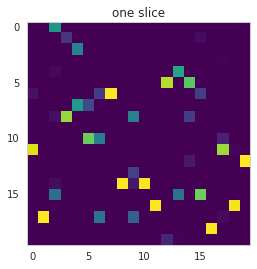

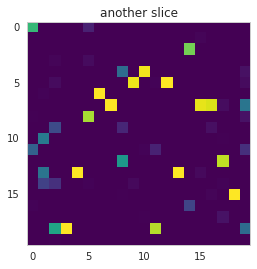

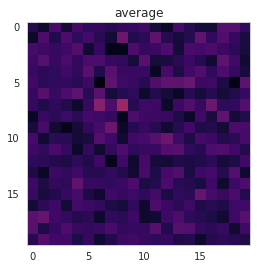

Iter: 176384
Loss: 0.1505
()


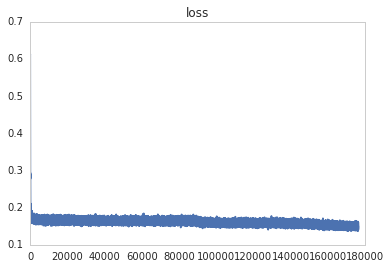

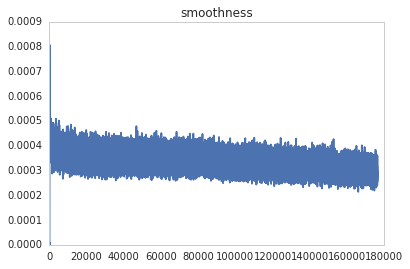

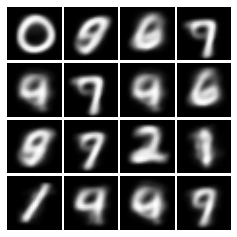

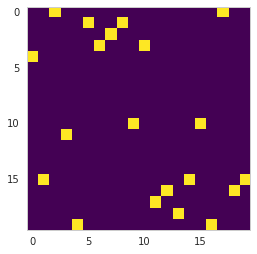

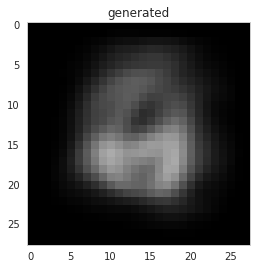

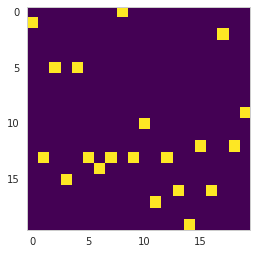

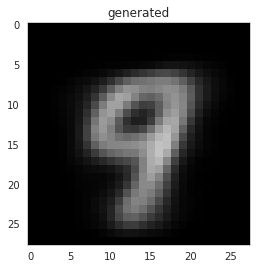

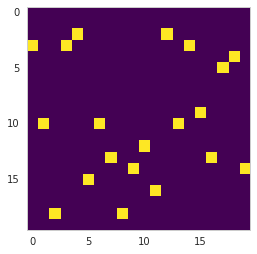

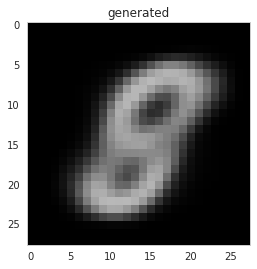

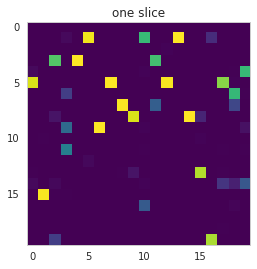

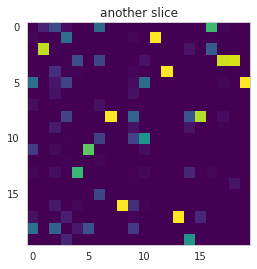

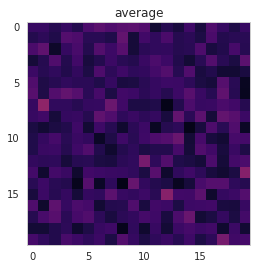

Iter: 181896
Loss: 0.1497
()


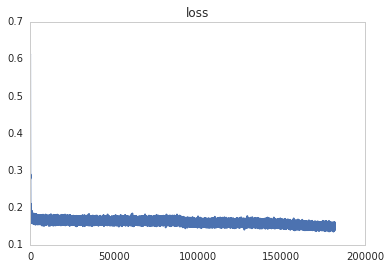

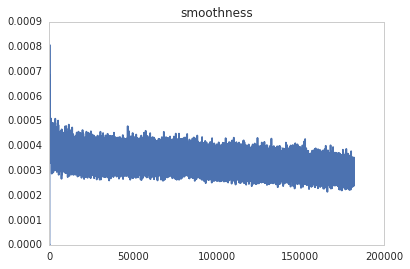

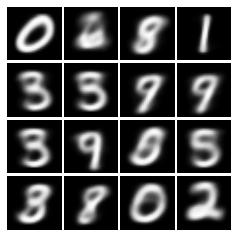

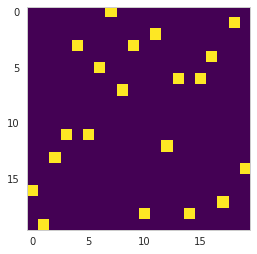

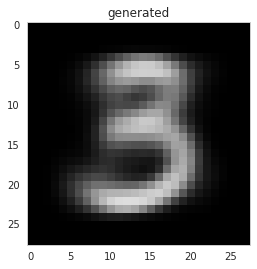

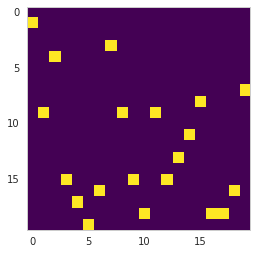

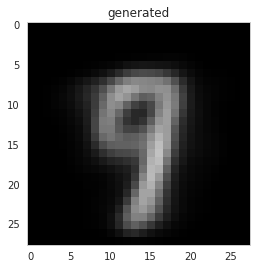

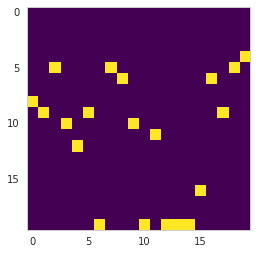

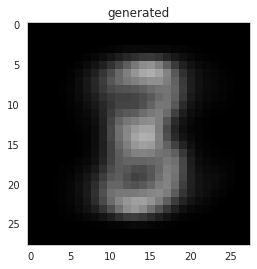

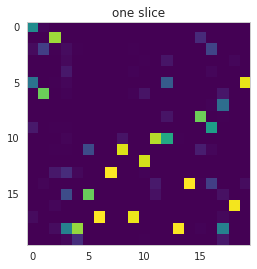

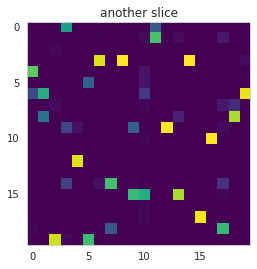

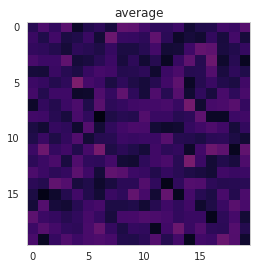

Iter: 187408
Loss: 0.1504
()


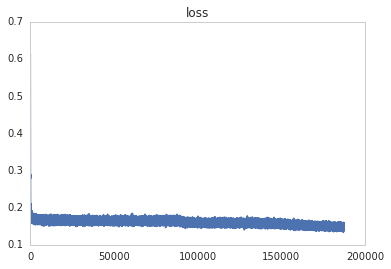

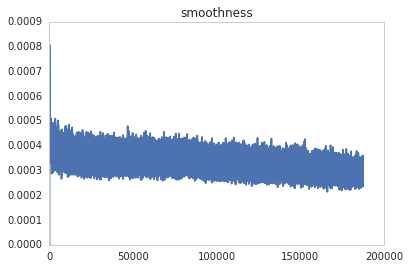

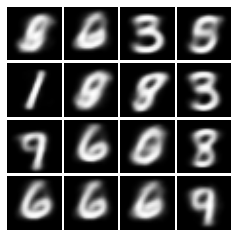

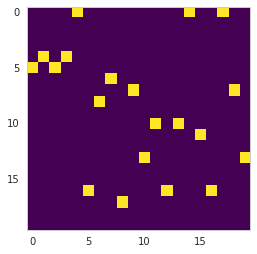

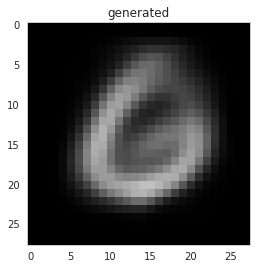

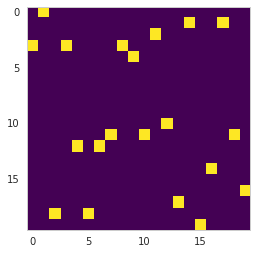

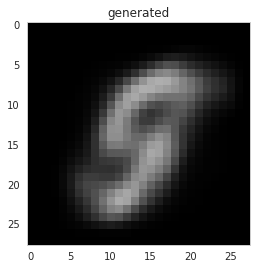

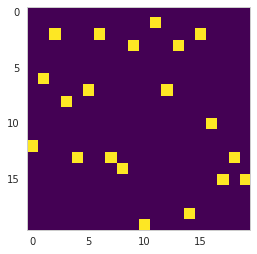

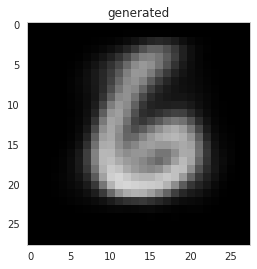

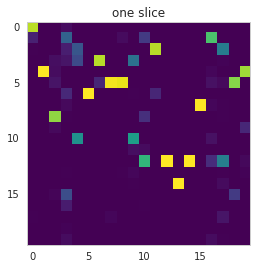

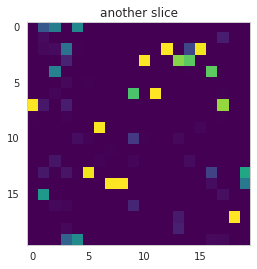

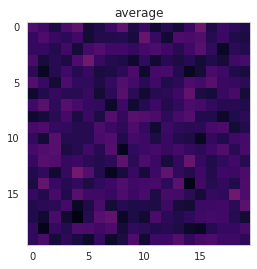

Iter: 192920
Loss: 0.1493
()


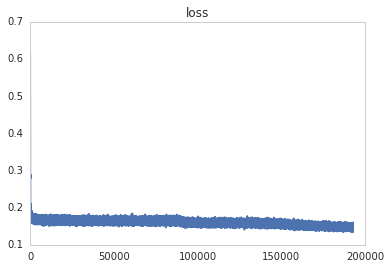

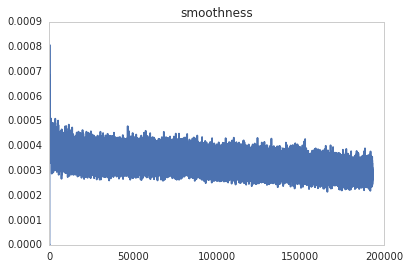

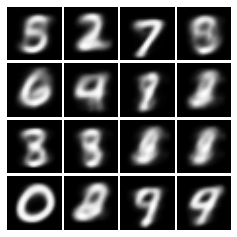

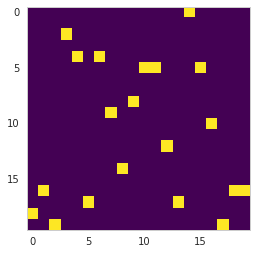

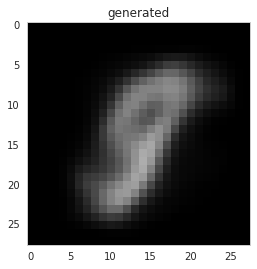

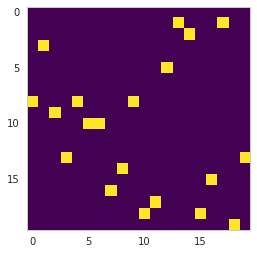

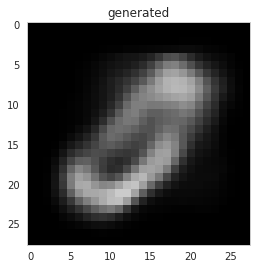

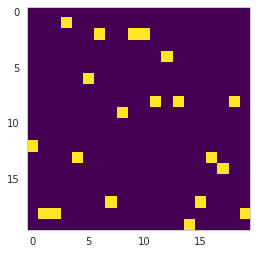

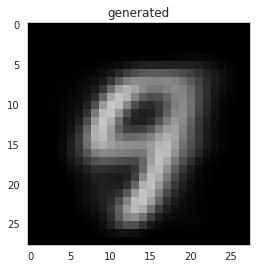

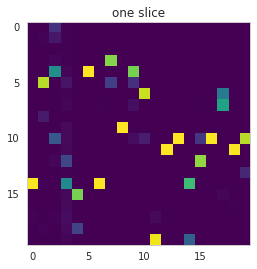

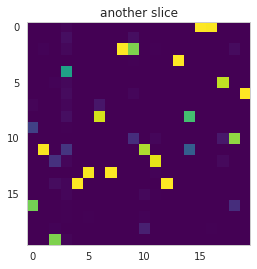

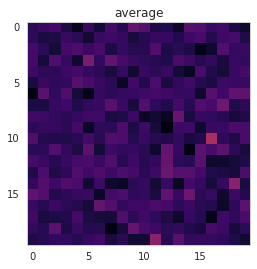

Iter: 198432
Loss: 0.1505
()


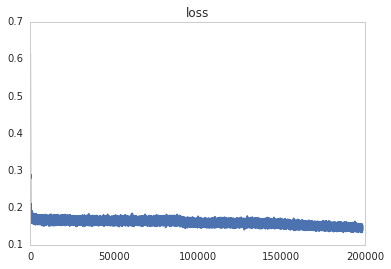

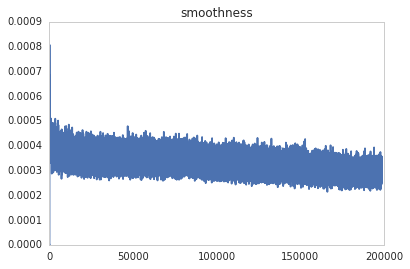

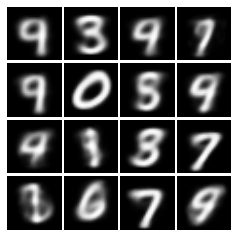

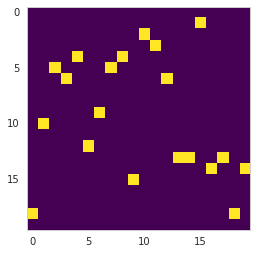

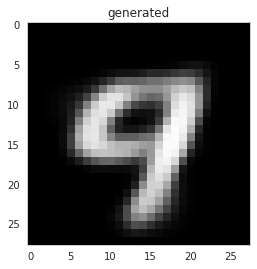

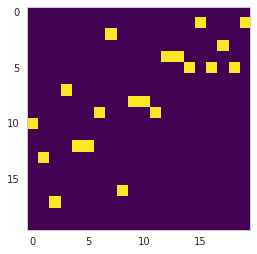

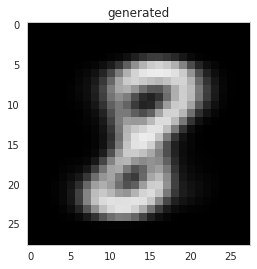

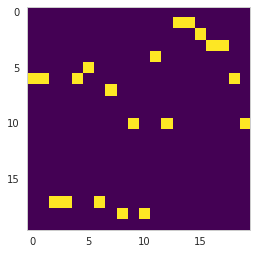

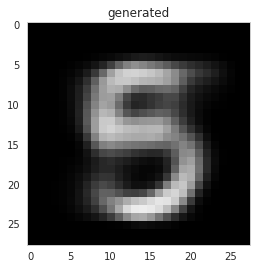

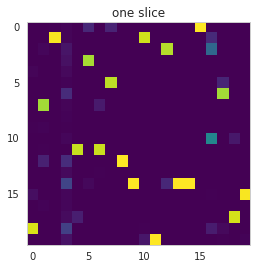

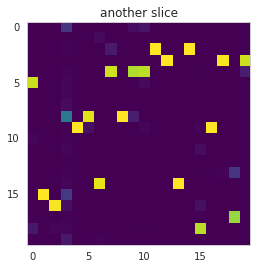

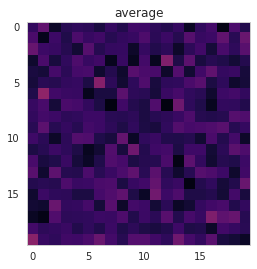

Iter: 203944
Loss: 0.1465
()


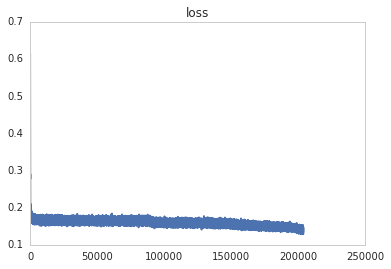

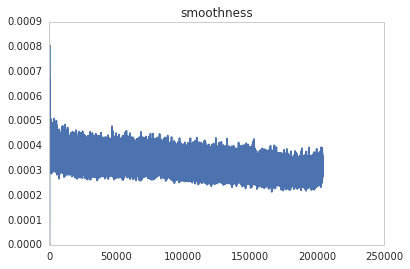

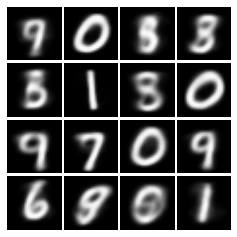

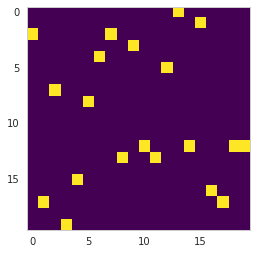

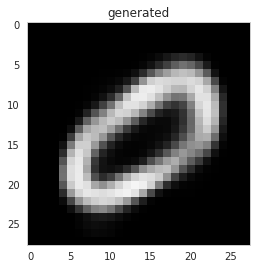

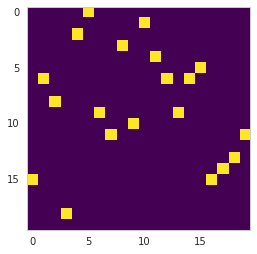

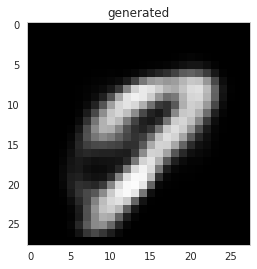

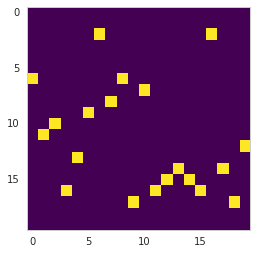

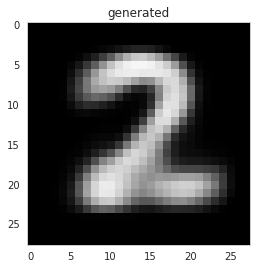

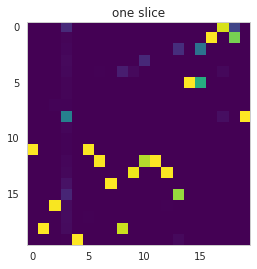

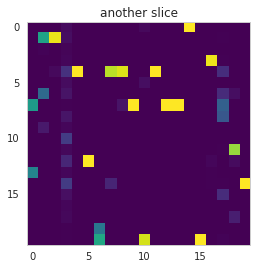

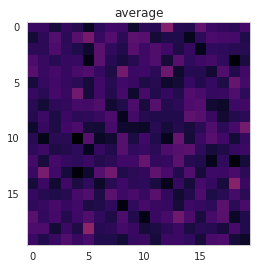

Iter: 209456
Loss: 0.1377
()


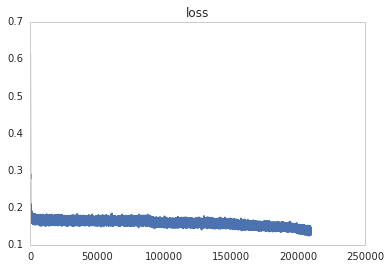

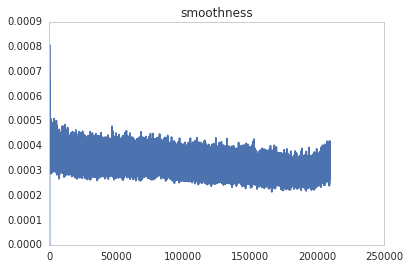

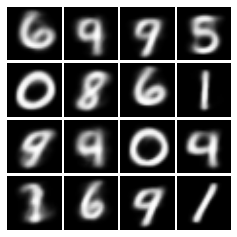

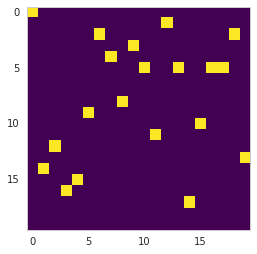

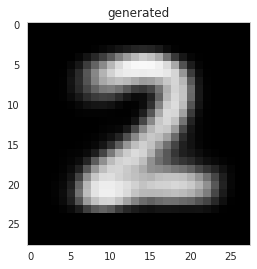

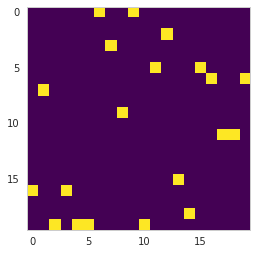

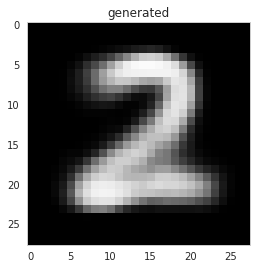

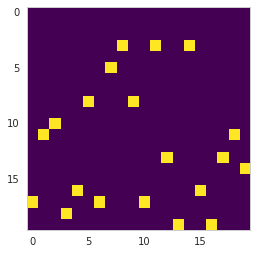

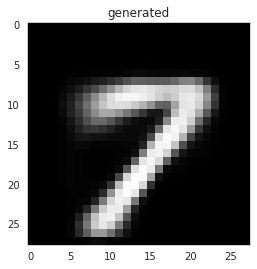

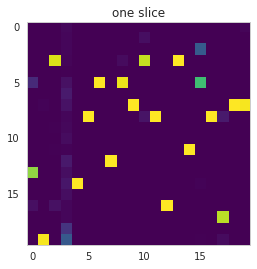

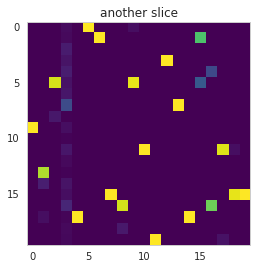

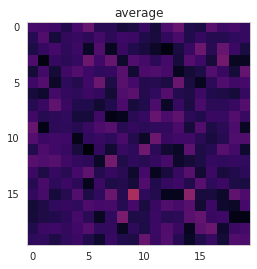

Iter: 214968
Loss: 0.1372
()


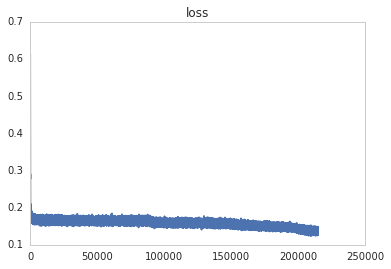

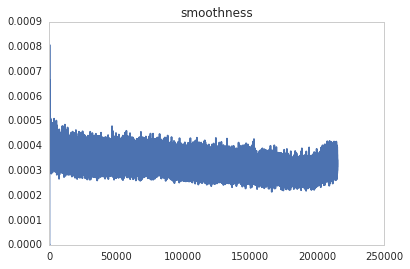

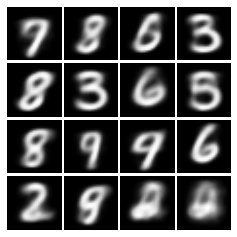

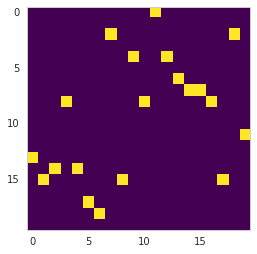

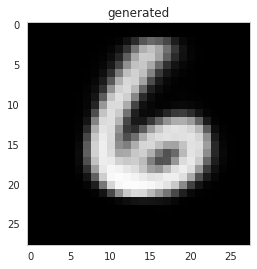

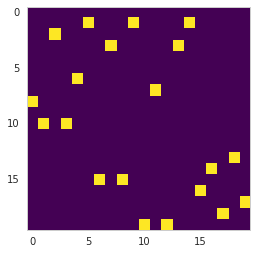

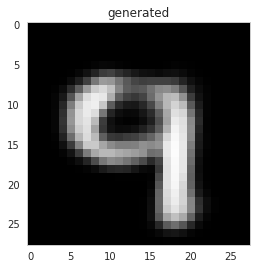

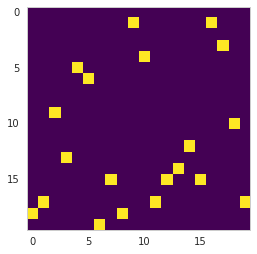

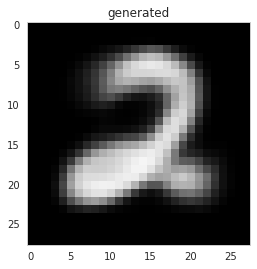

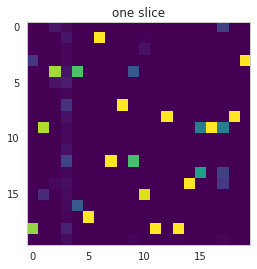

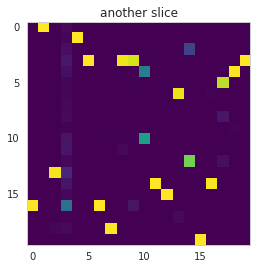

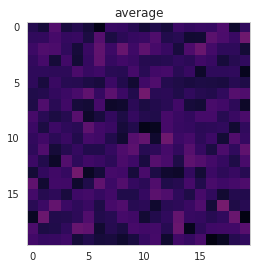

Iter: 220480
Loss: 0.1314
()


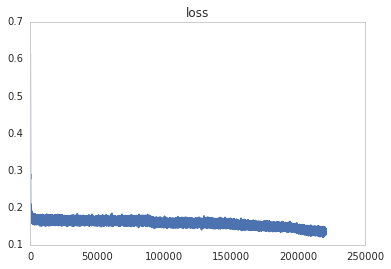

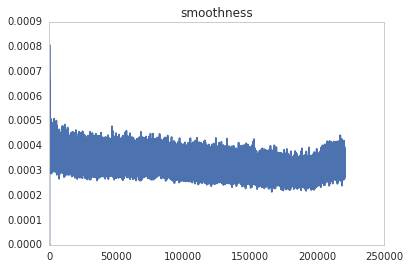

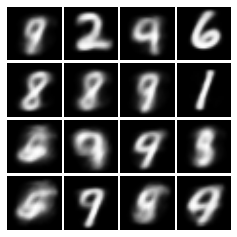

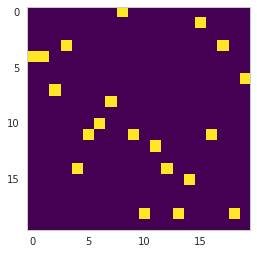

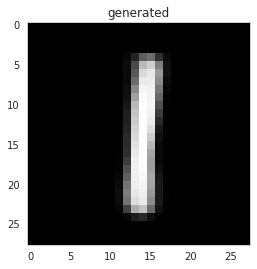

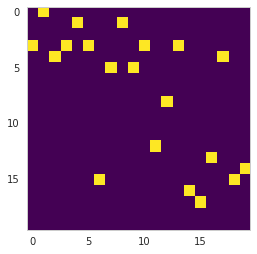

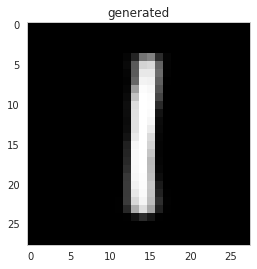

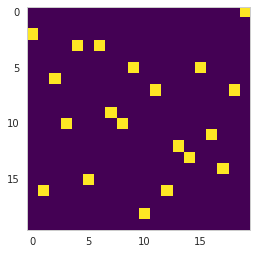

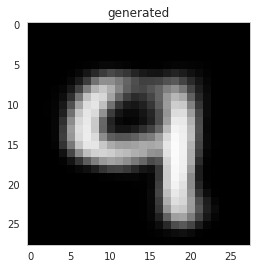

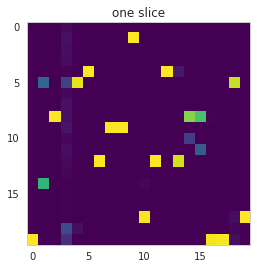

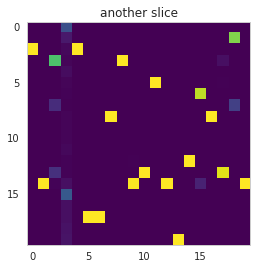

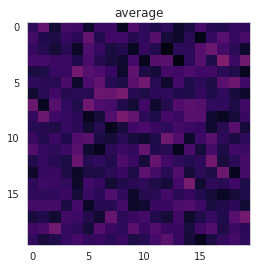

Iter: 225992
Loss: 0.1331
()


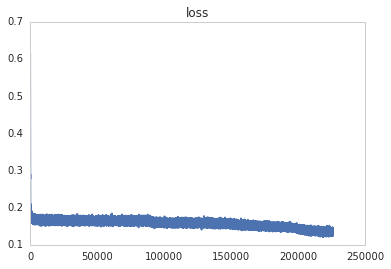

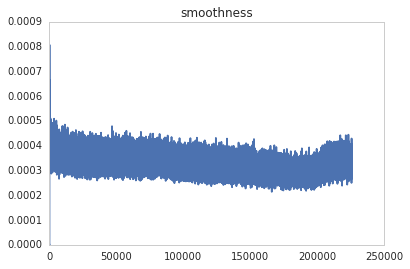

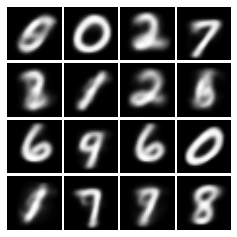

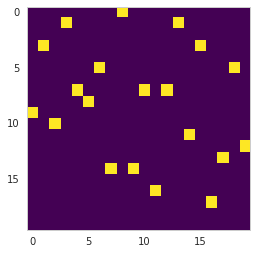

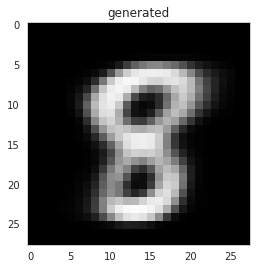

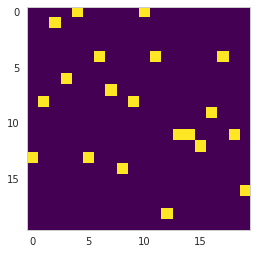

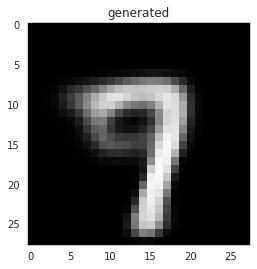

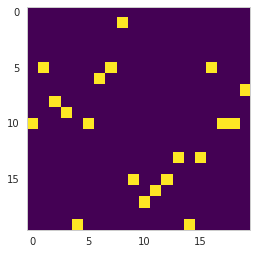

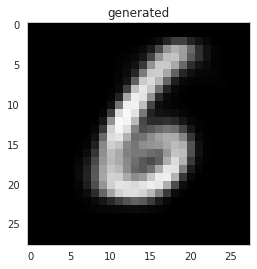

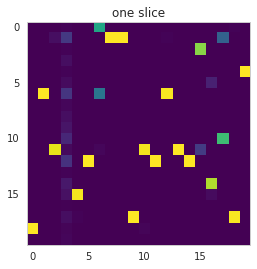

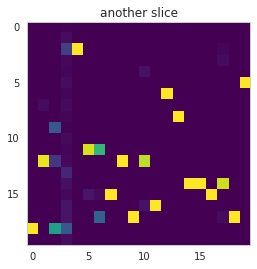

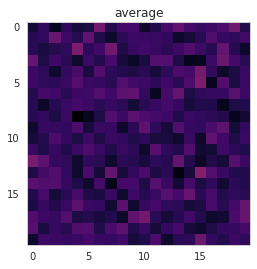

Iter: 231504
Loss: 0.1377
()


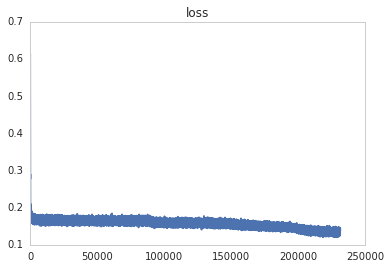

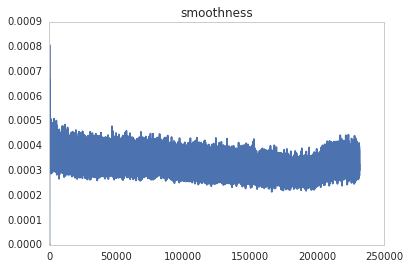

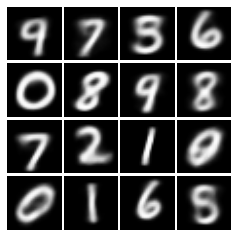

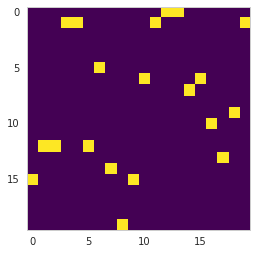

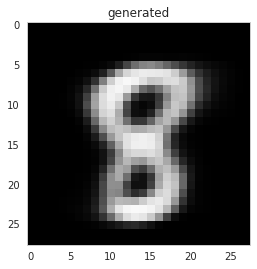

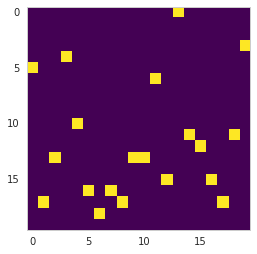

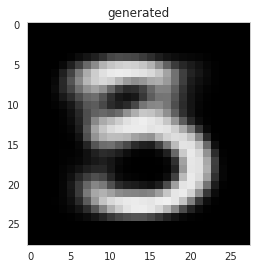

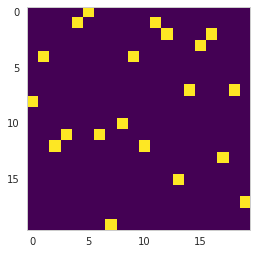

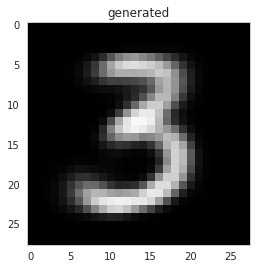

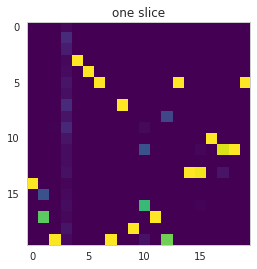

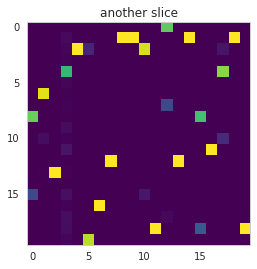

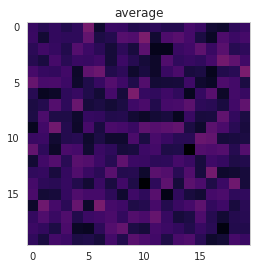

Iter: 237016
Loss: 0.1408
()


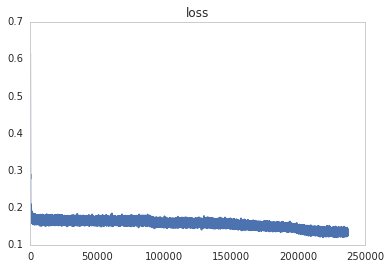

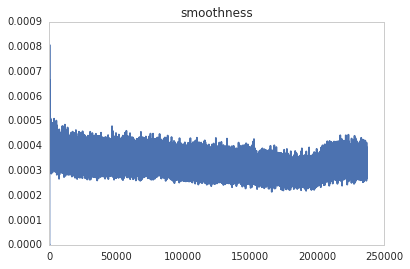

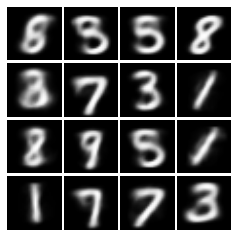

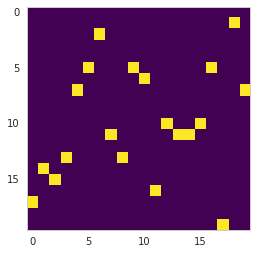

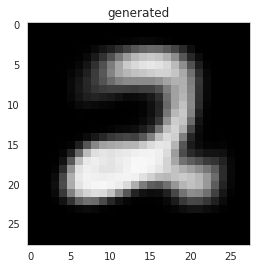

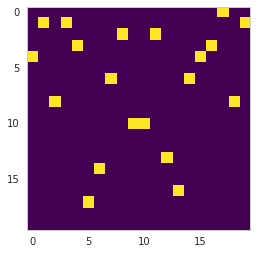

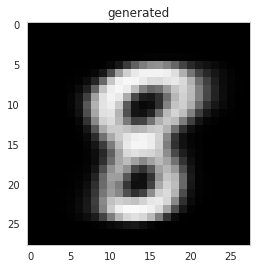

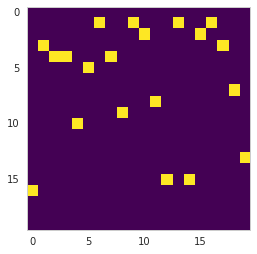

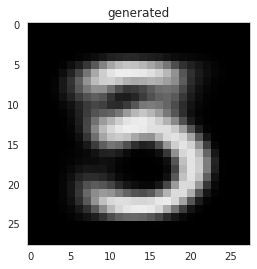

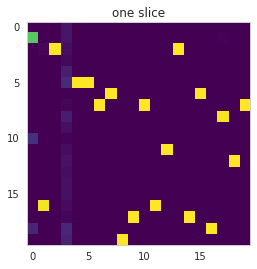

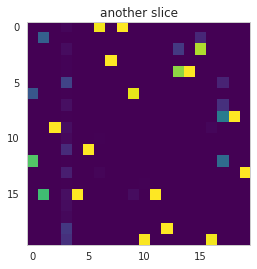

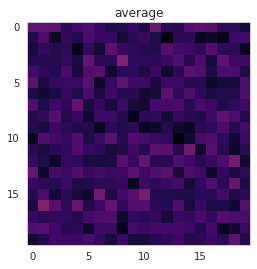

Iter: 242528
Loss: 0.132
()


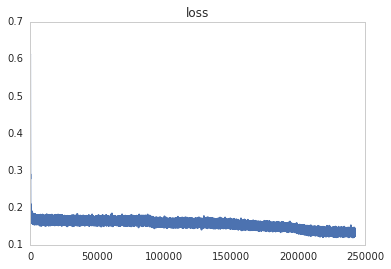

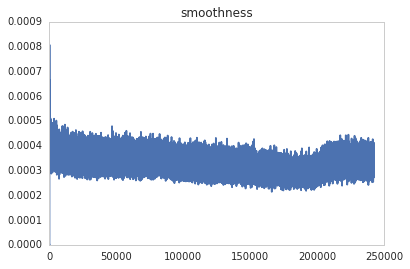

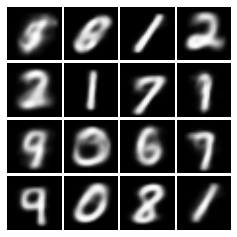

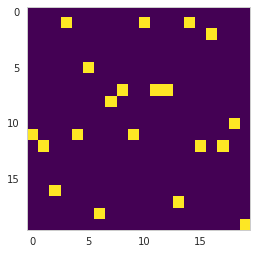

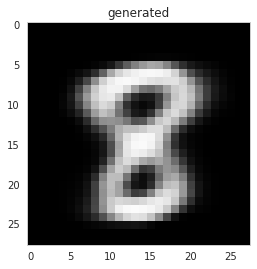

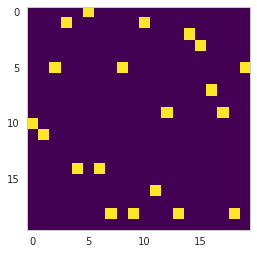

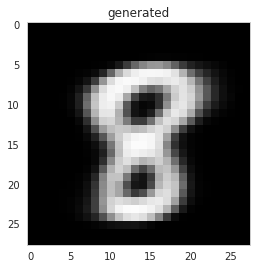

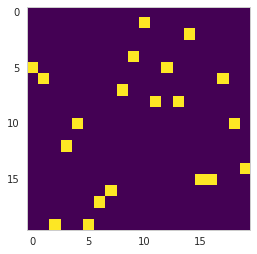

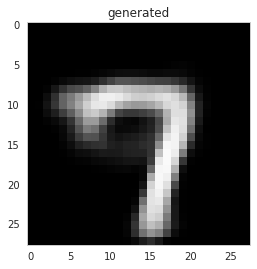

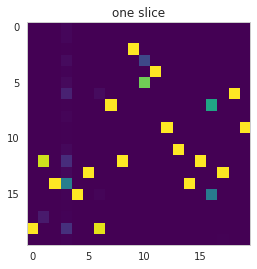

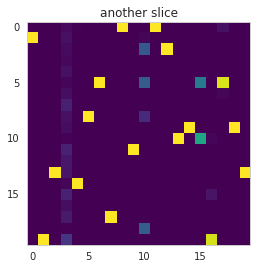

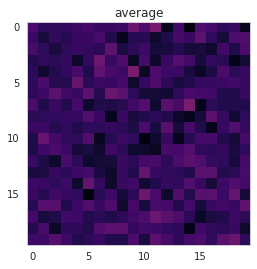

Iter: 248040
Loss: 0.1266
()


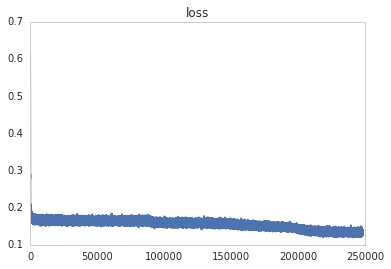

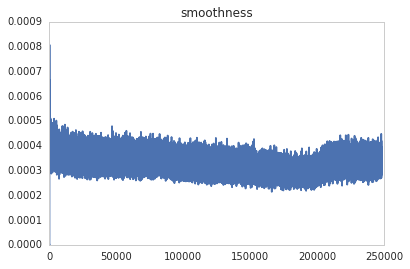

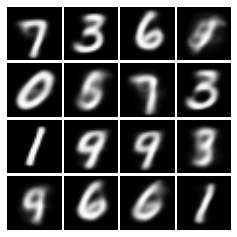

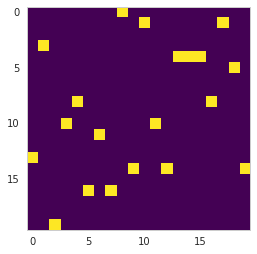

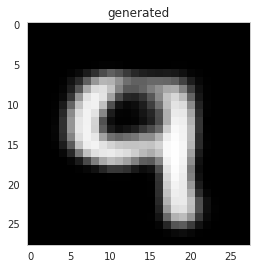

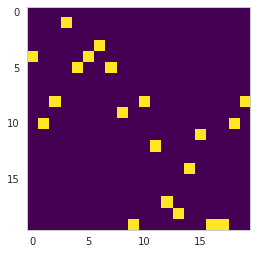

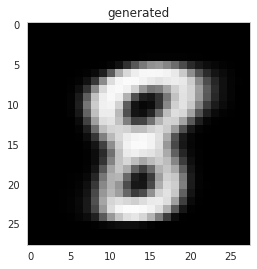

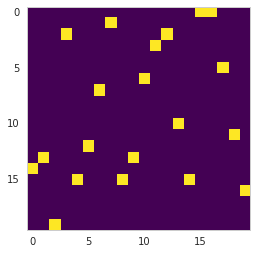

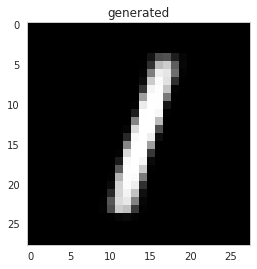

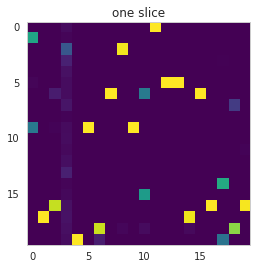

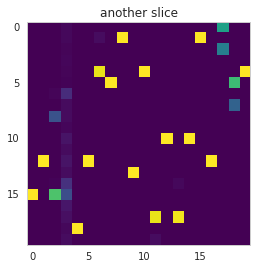

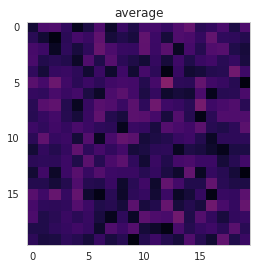

Iter: 253552
Loss: 0.1332
()


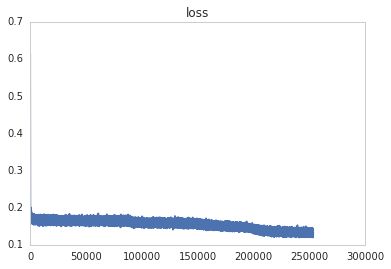

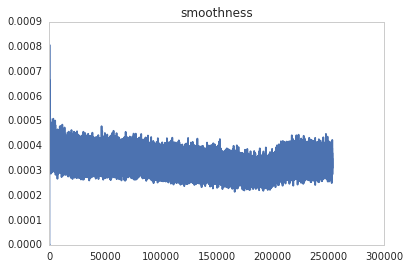

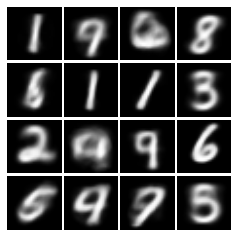

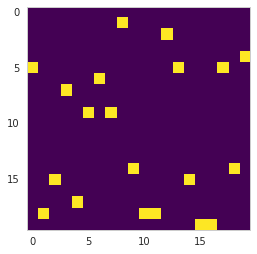

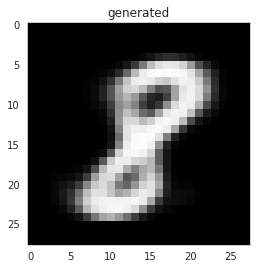

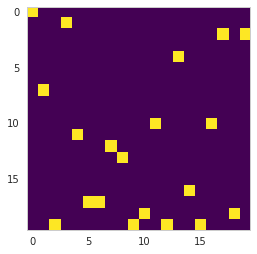

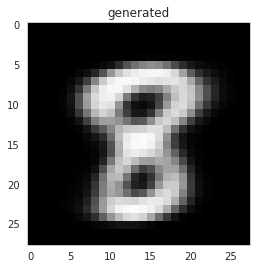

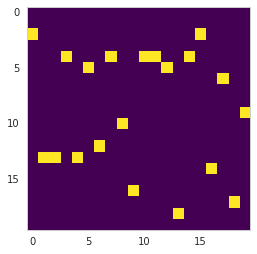

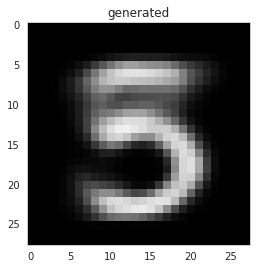

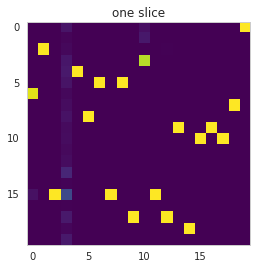

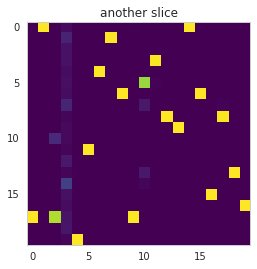

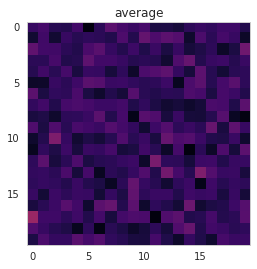

Iter: 259064
Loss: 0.1359
()


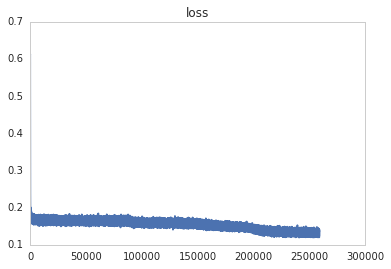

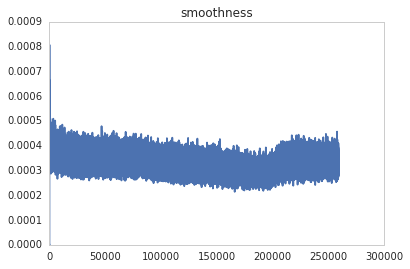

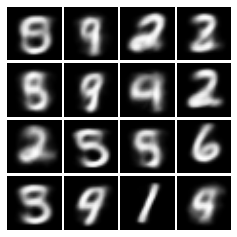

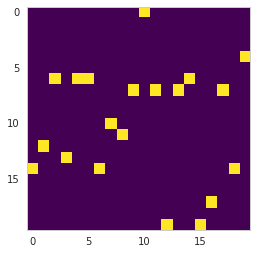

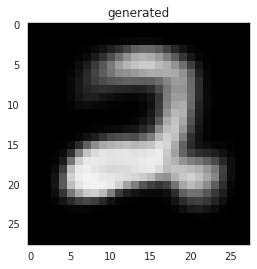

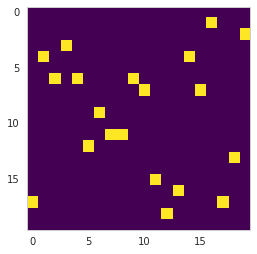

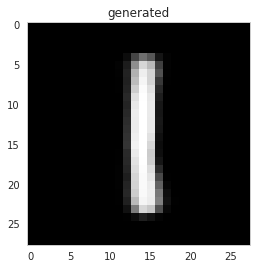

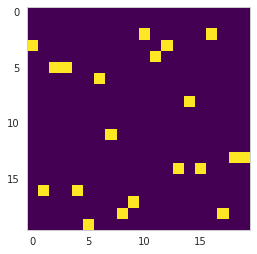

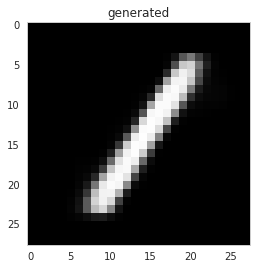

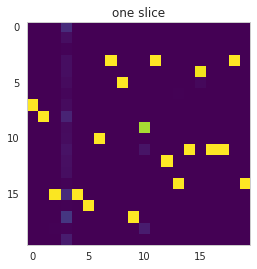

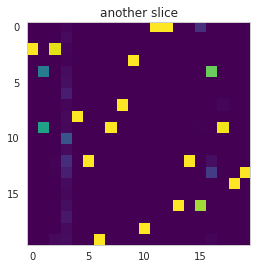

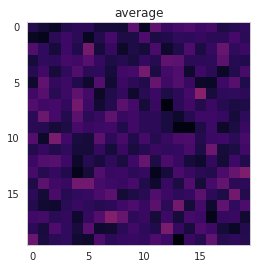

Iter: 264576
Loss: 0.1295
()


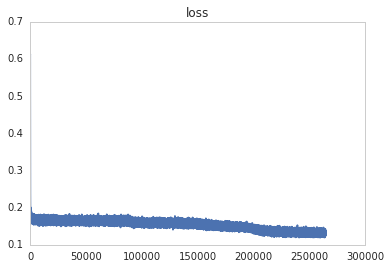

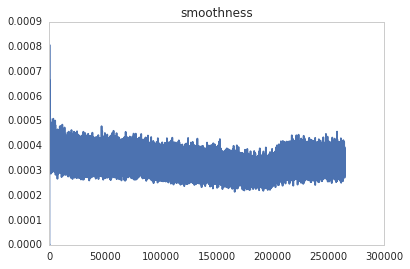

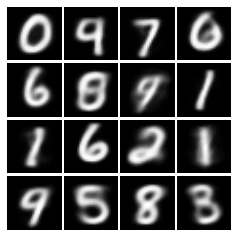

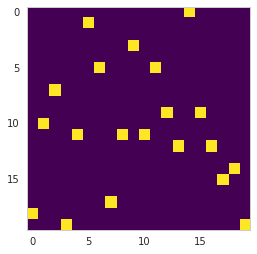

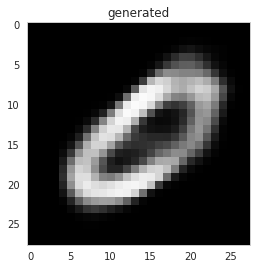

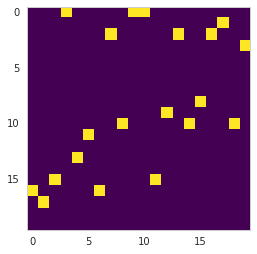

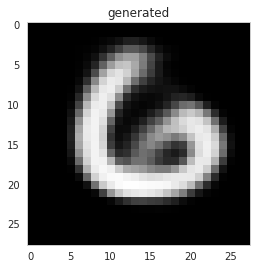

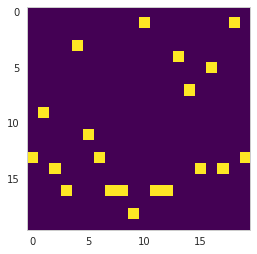

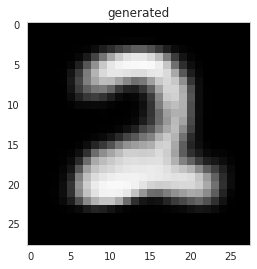

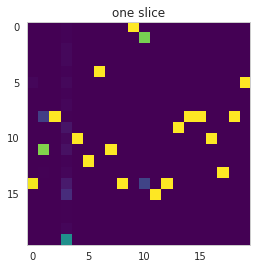

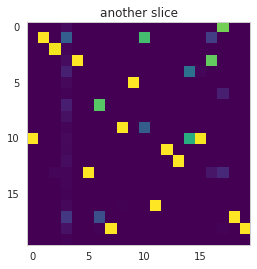

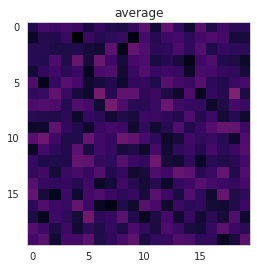

Iter: 270088
Loss: 0.1355
()


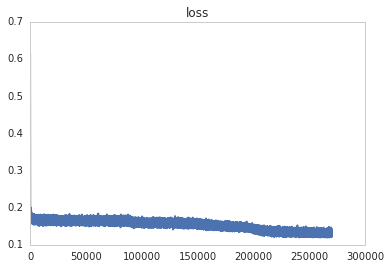

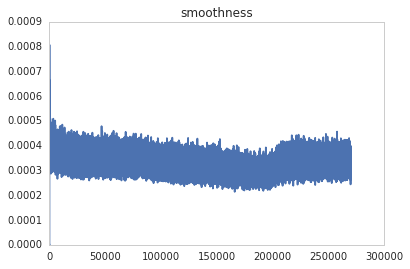

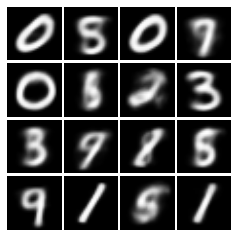

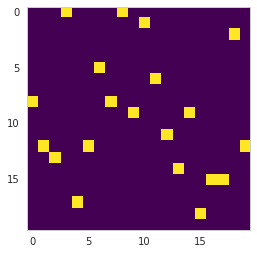

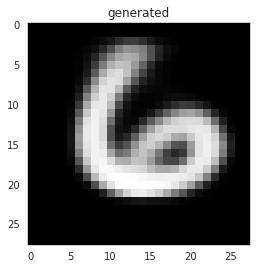

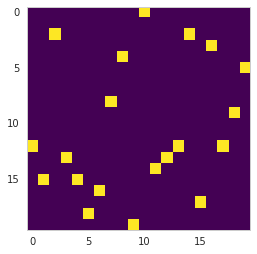

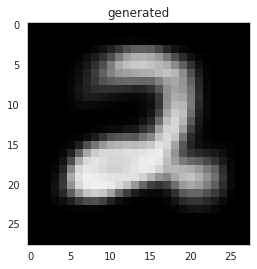

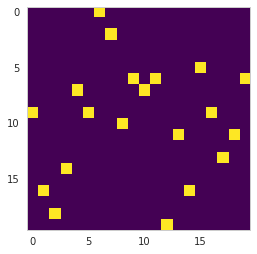

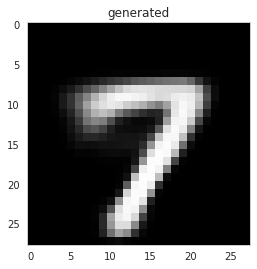

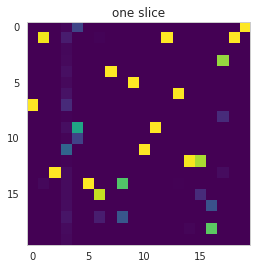

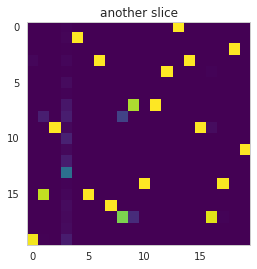

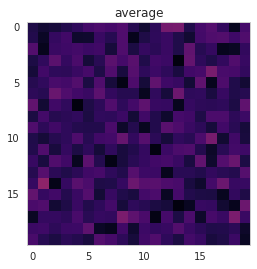

Iter: 275600
Loss: 0.1328
()


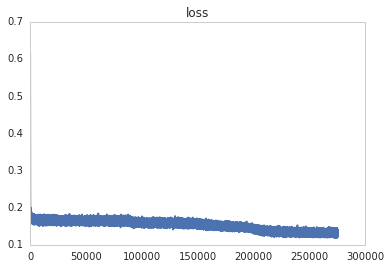

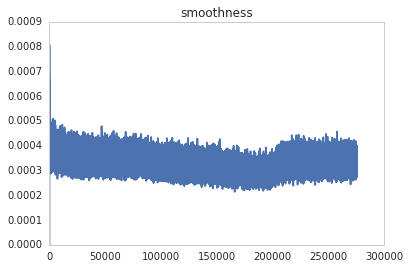

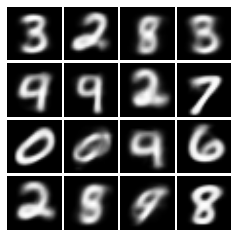

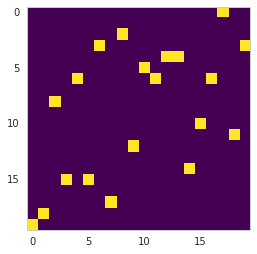

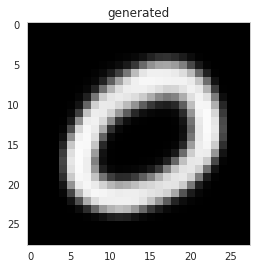

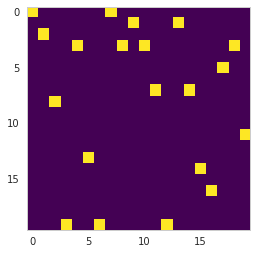

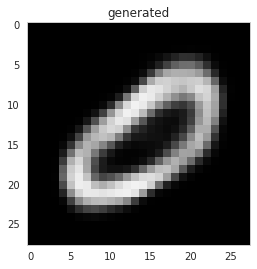

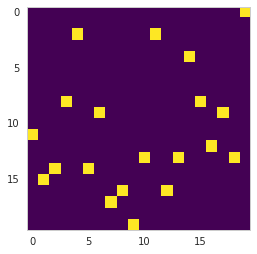

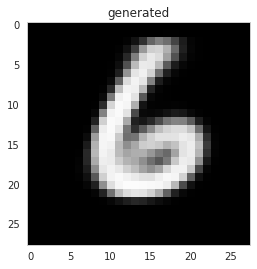

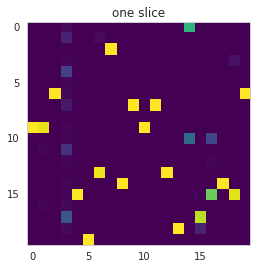

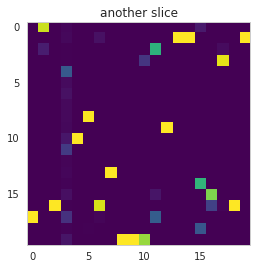

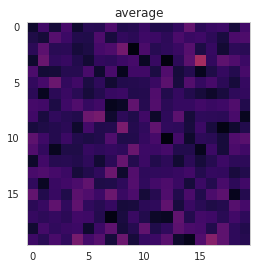

Iter: 281112
Loss: 0.1319
()


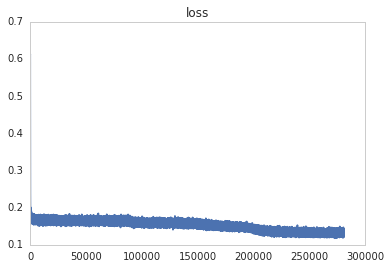

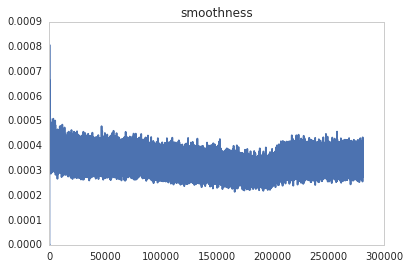

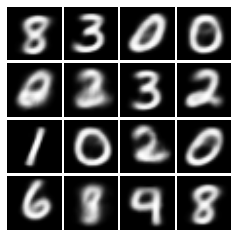

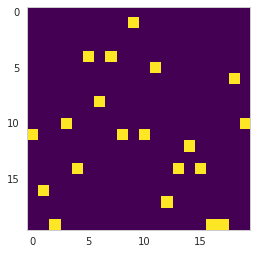

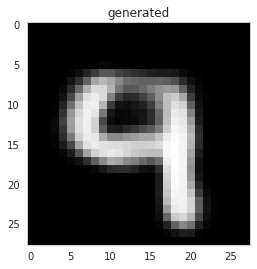

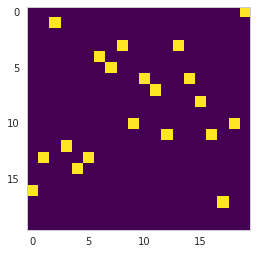

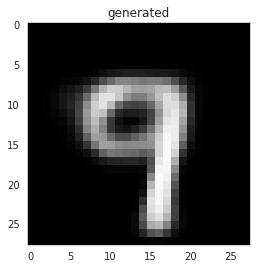

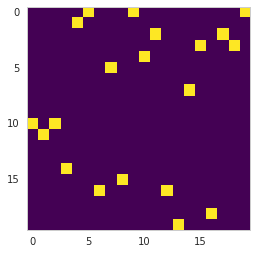

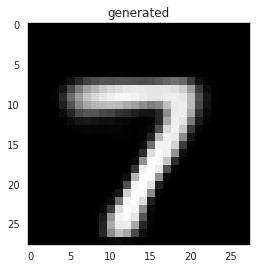

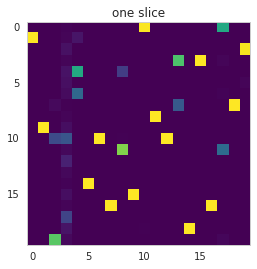

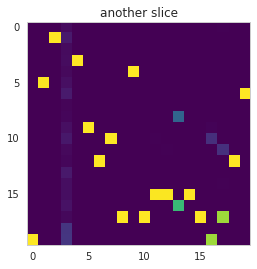

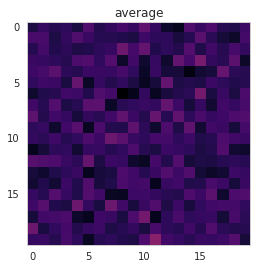

Iter: 286624
Loss: 0.1364
()


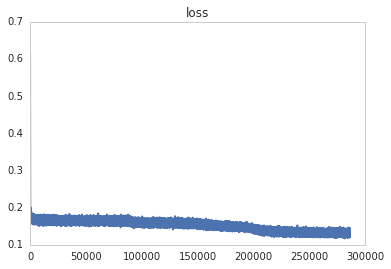

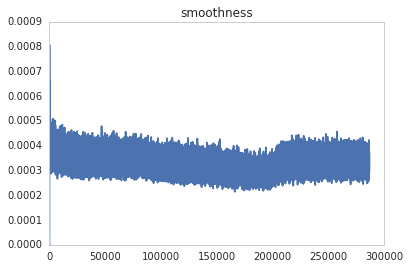

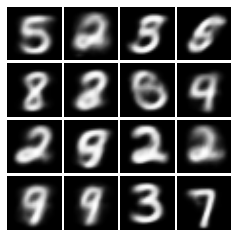

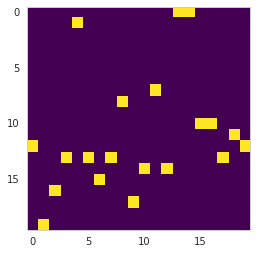

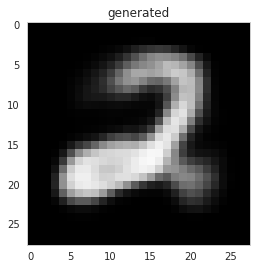

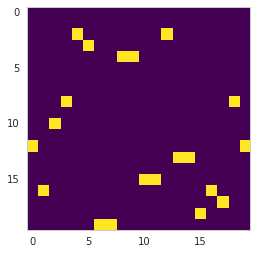

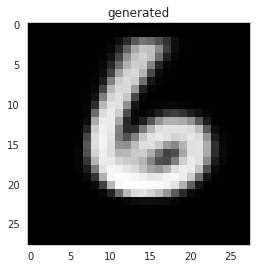

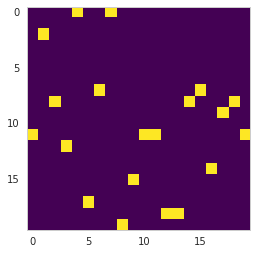

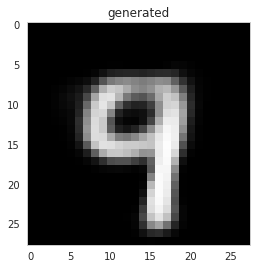

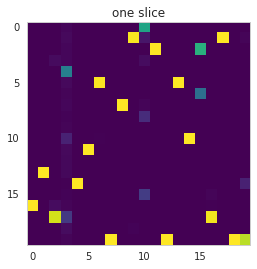

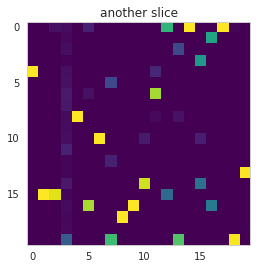

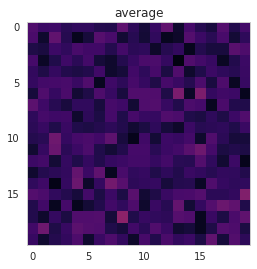

Iter: 292136
Loss: 0.1278
()


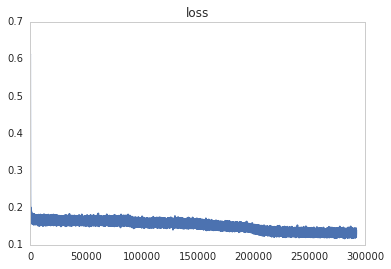

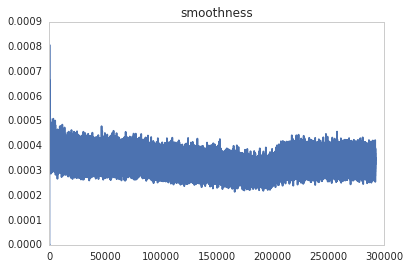

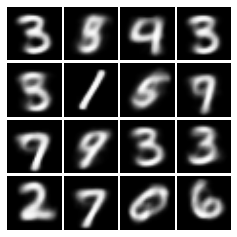

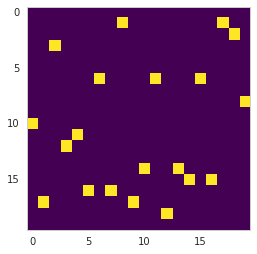

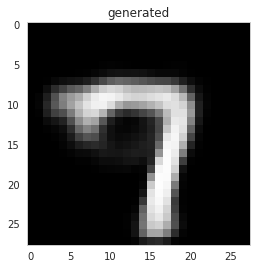

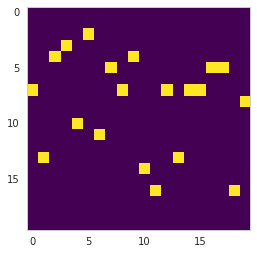

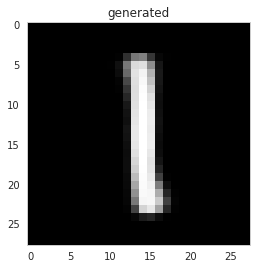

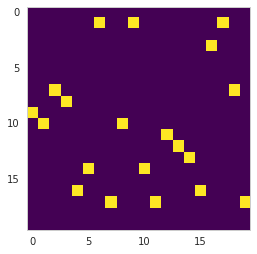

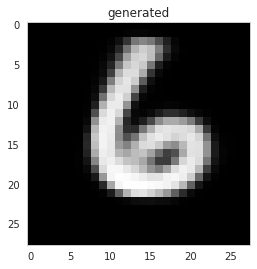

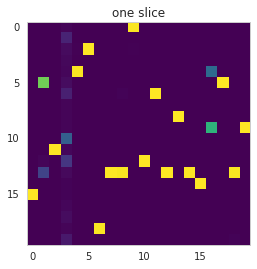

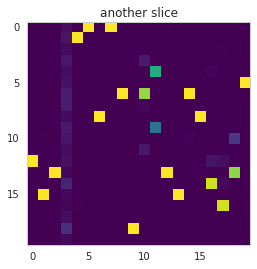

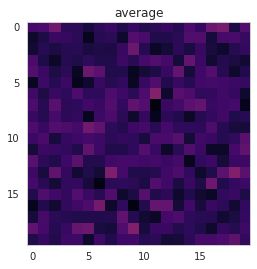

Iter: 297648
Loss: 0.1333
()


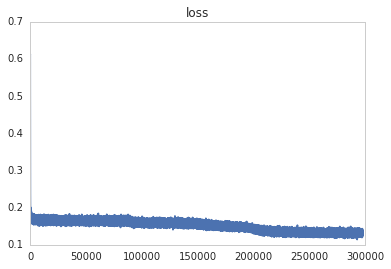

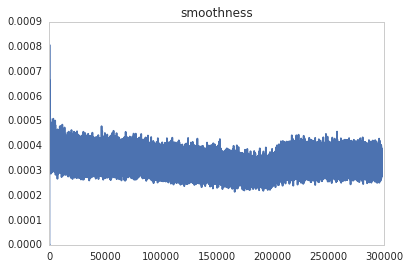

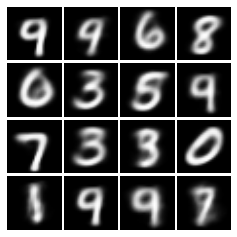

KeyboardInterrupt: 

In [403]:
alphabet = "abcdefghijklmnopqrstuvwxyz "
sns.set_style("whitegrid", {'axes.grid' : False})

%matplotlib inline
for it in range(1000000):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, loss, symbol_mat_val, entropy_row_val,entropy_total_val, \
    smoothness_val, average_p_val, p_mat_val = sess.run(
        [solver, vae_loss, symbol_mat, entropy_row, total_entropy, 
         total_entropy, symbols_average, p_mat], feed_dict={X: X_mb, is_training_ph:1})
    
#     print np.sum(p_mat_val[0], axis = 1)
#     print p_mat_val[0]
#     break
    global_smoothness_record.append(smoothness_val)
    record.append(loss)
    if it % 5512 == 0:
        
        for i in range(3):
            code = np.eye(k)[np.random.randint(0,high=k,size=d)].T.flatten().reshape([1,k,d])
            plt.imshow(code[0], interpolation = 'nearest', cmap = 'viridis')
            plt.show()
            generated_images = sess.run(
                pixels_generated, feed_dict={input_sequence: code, is_training_ph:0})[0].reshape([-1,28,28])
            plt.imshow(generated_images[0], interpolation = 'nearest', cmap = 'gray', vmin = 0, vmax= 1)
            plt.title("generated")
            plt.show()
        
        
#         print entropy_val
#         plt.hist(entropy_val)
#         plt.title("slice entropy "+ str(np.min(entropy_val)) )
#         plt.show()

#         plt.hist(entropy_total_val)
#         plt.title("total entropy "+ str(np.min(entropy_total_val)))
#         plt.show()
#         plt.hist(symbol_mat_val.flatten())
#         plt.title("all probabilities")
#         plt.show()
        plt.imshow(symbol_mat_val[0], interpolation = 'nearest', cmap = 'viridis', vmin = 0, vmax= 1)
        plt.title("one slice")
        plt.show()
        plt.imshow(symbol_mat_val[1], interpolation = 'nearest', cmap = 'viridis', vmin = 0, vmax= 1)
        plt.title("another slice")
        plt.show()
        plt.imshow(average_p_val, interpolation = 'nearest', cmap = 'inferno', vmin = 0, vmax= .3)
        plt.title("average")
        plt.show()
#         plt.hist(average_p_val.flatten())
#         plt.title("average_p_val flat")
#         plt.show()
#         plt.hist(average_p_val.flatten())
#         plt.title("average_p_val flat")
#         plt.show()
        
        
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()
        plt.plot(record)
        plt.title("loss")
        plt.show()
        
        plt.plot(global_smoothness_record)
        plt.title("smoothness")
        plt.show()
#         samples = sess.run(X_samples, feed_dict={z: np.random.randn(16, z_dim)})
        samples = sess.run(pixels_pred, feed_dict={X: X_mb[:16], is_training_ph:0})

        fig = plot(samples)
        plt.show()
        i += 1


aaacaa


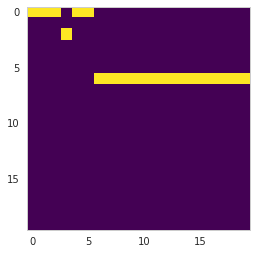

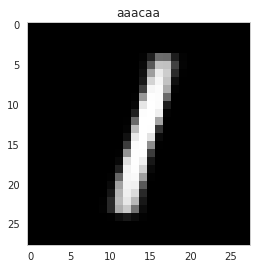

aaabaa


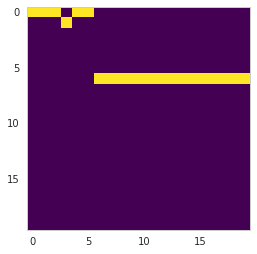

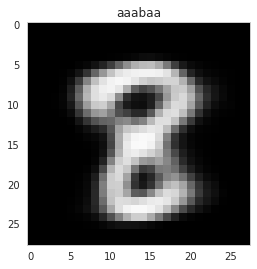

aaacaa


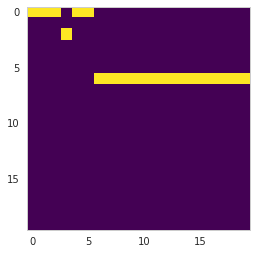

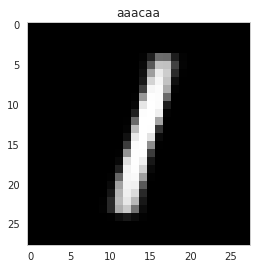

aaadaa


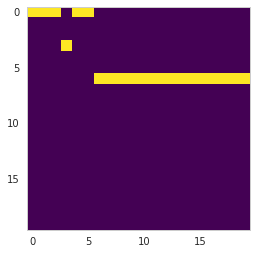

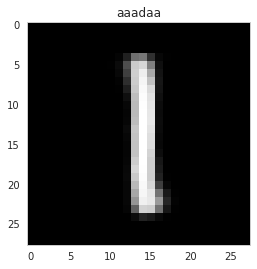

aaaeaa


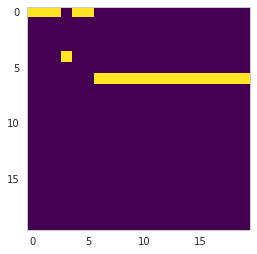

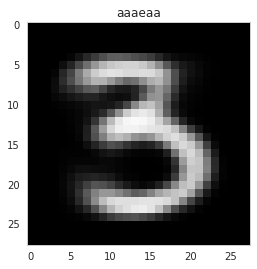

aaafaa


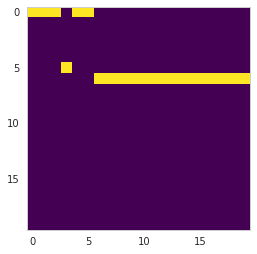

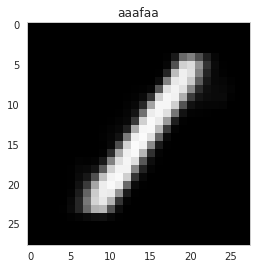

aaagaa


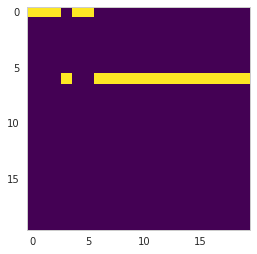

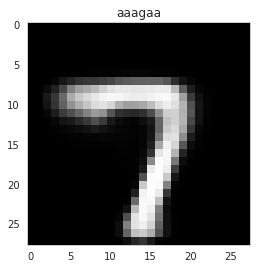

aaahaa


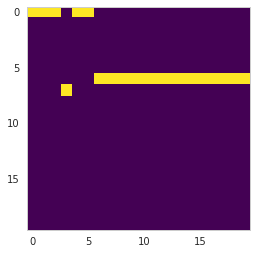

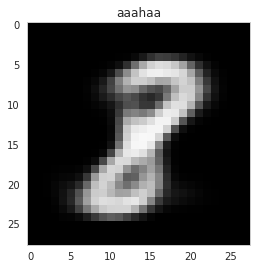

raaaaaaaaaaaaaaaaaaa


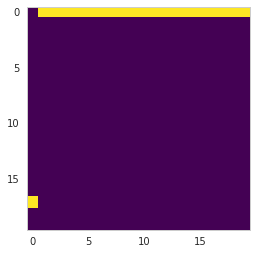

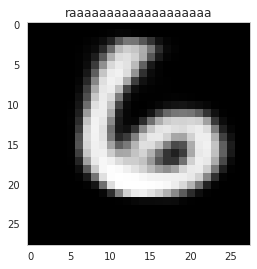

araaaaaaaaaaaaaaaaaa


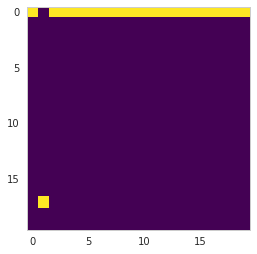

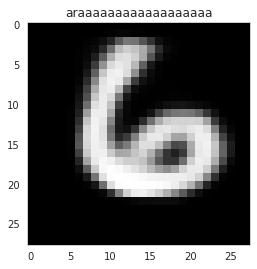

aaraaaaaaaaaaaaaaaaa


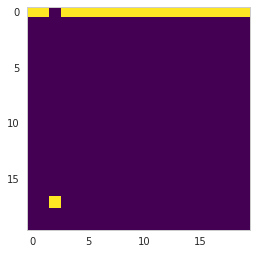

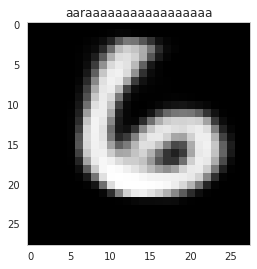

aaaraaaaaaaaaaaaaaaa


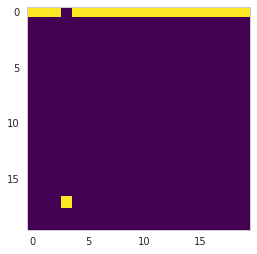

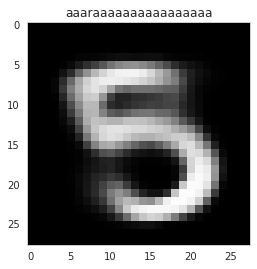

aaaaraaaaaaaaaaaaaaa


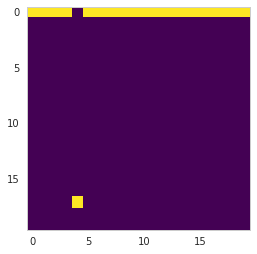

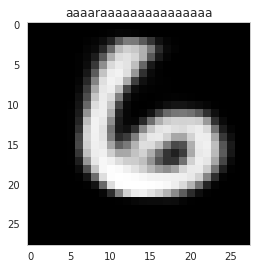

aaaaaraaaaaaaaaaaaaa


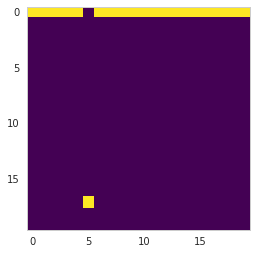

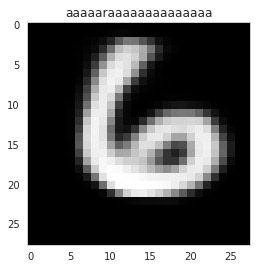

aaaaaaraaaaaaaaaaaaa


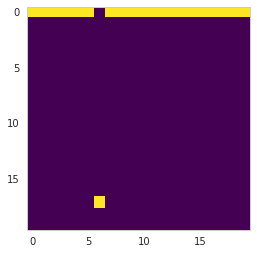

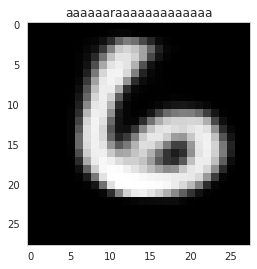

aaaaaaaraaaaaaaaaaaa


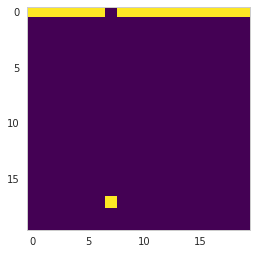

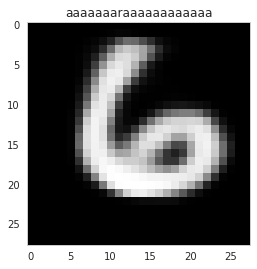

aaaaaaaaraaaaaaaaaaa


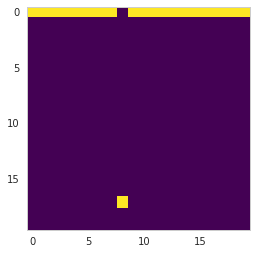

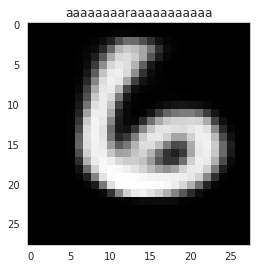

aaaaaaaaaraaaaaaaaaa


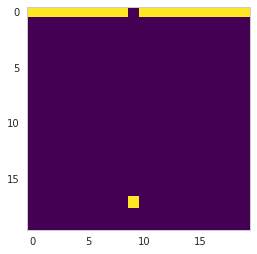

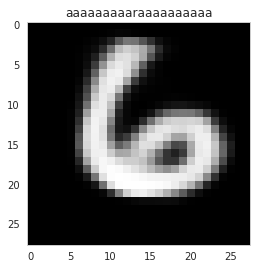

aaaaaaaaaaraaaaaaaaa


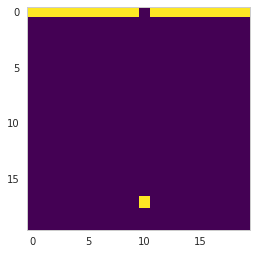

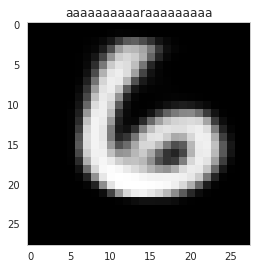

aaaaaaaaaaaraaaaaaaa


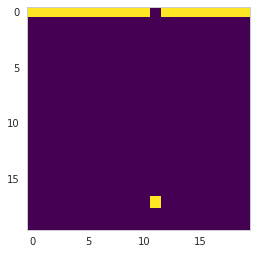

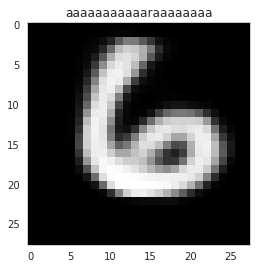

aaaaaaaaaaaaraaaaaaa


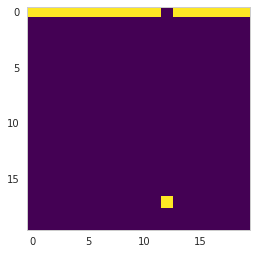

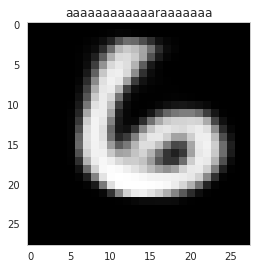

aaaaaaaaaaaaaraaaaaa


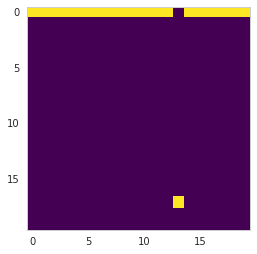

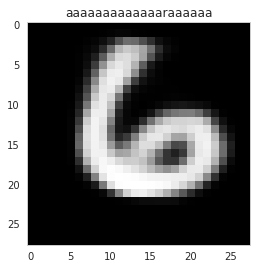

aaaaaaaaaaaaaaraaaaa


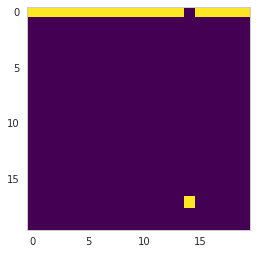

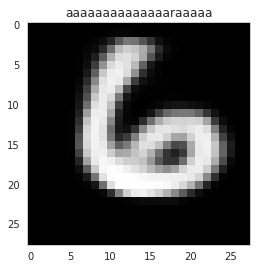

aaaaaaaaaaaaaaaraaaa


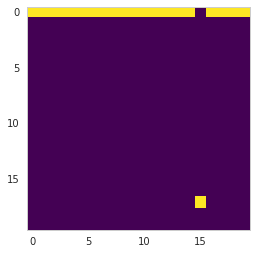

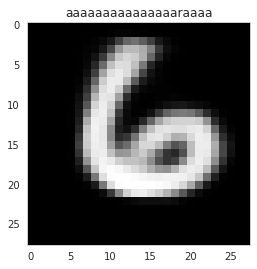

aaaaaaaaaaaaaaaaraaa


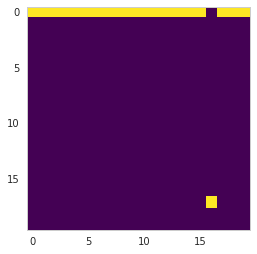

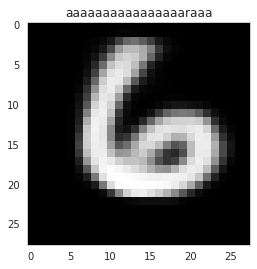

aaaaaaaaaaaaaaaaaraa


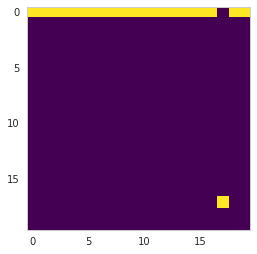

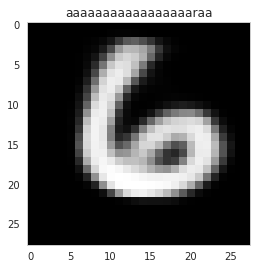

aaaaaaaaaaaaaaaaaara


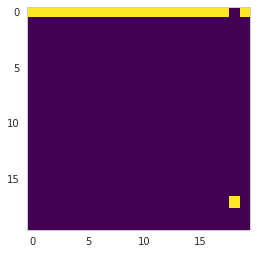

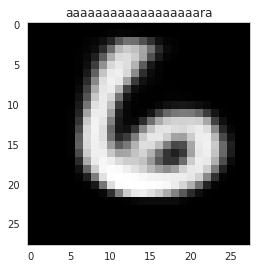

aaaaaaaaaaaaaaaaaaar


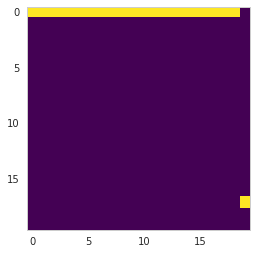

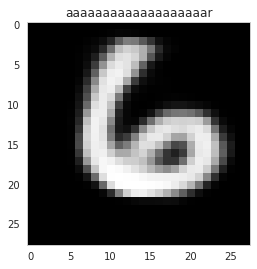

In [437]:
def make_image(letters_in):
    print letters_in
    letters = letters_in[:k]
    letters = filter(lambda x: x in alphabet, letters)
    letters = letters.ljust(k)
    number_sequence = [list(alphabet).index(l) for l in letters]
    number_sequence = np.array([x % k for x in number_sequence])
    code = np.eye(k)[number_sequence].T.flatten().reshape([1,k,d])
    plt.imshow(code[0], interpolation = 'nearest', cmap = 'viridis')
    plt.show()
    generated_images = sess.run(pixels_generated, feed_dict={input_sequence: code, is_training_ph:0})[0].reshape([-1,28,28])
    
    plt.imshow(generated_images[0], interpolation = 'nearest', cmap = 'gray', vmin = 0, vmax= 1)
    plt.title(letters_in[:40])
    plt.show()
    
# make_image("cannon is a cuck")
# make_image("patrick is a cuck")
# make_image("isaac is a cuck")
make_image("aaacaa")
make_image("aaabaa")
make_image("aaacaa")
make_image("aaadaa")
make_image("aaaeaa")
make_image("aaafaa")
make_image("aaagaa")
make_image("aaahaa")

for i in range(k):
    s = list("a"*k)
    s[i] = 'r'
    letters = "".join(s)
    make_image(letters)